In [1]:
import os
import pywt
import pydot
import numpy as np
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy import signal, stats
from scipy.interpolate import interp1d
from scipy.io import wavfile, loadmat
from collections import defaultdict

In [2]:
def hann_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.5 - 0.5*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])


def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir',
                        resample_method='interp1d',
                        fir_method='kaiser', gpass=1, gstop=80,
                        correct_by_gd=True, gd_padding='periodic',
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda. Esta es la que se toma
        en cuenta al momento de hacer el último corte (por ende, si 
        busca samplear a 2kHz, seleccione este parámetro en 1kHz).
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. 'cut' es un método no convencional en el que
        se todas las frecuencias filtradas de la magnitud se hacen 0. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'decimation'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'decimation' se  realiza una 
        decimación a la señal por un parámetro "N_dec" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    -----------
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula el paso de la decimación
    N_dec = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = 2 * freq_stop
    
    # Selección del método del pasabajos
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        _, signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                      freq_stop, method=lp_method, 
                                      fir_method=fir_method, gpass=gpass, 
                                      gstop=gstop, plot_filter=plot_filter,
                                      correct_by_gd=correct_by_gd,
                                      gd_padding=gd_padding,
                                      normalize=normalize)
    elif method == 'cut':
        signal_lp = lowpass_cut_frequency(signal_in, samplerate, 
                                          freq_stop)
    else:
        raise Exception('Opción de método no válido. Por favor, ingrese'
                        ' un valor válido.')
    
    # Selección del método de resampleo
    if resample_method == 'resample':
        return new_rate, signal.resample(signal_lp, 
                                         len(signal_lp)//N_dec)
    
    elif resample_method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_lp, 
                                              len(signal_lp)//N_dec, 1)
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_lp))
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_lp) - 1, len(signal_lp)//N_dec)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_lp)

        return new_rate, f(x_new)
    
    elif resample_method == 'decimation':
        # Calculo de la nueva tasa de muestreo
        new_rate = samplerate // N_dec
        
        return new_rate, decimation_signal(signal_lp, N_decimate=N_dec)

                     
def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, correct_by_gd=True,
                   gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - samplerate: Tasa de muestreo de la señal utilizada
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - cutoff_freq: Frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - ['fir']: Se implementa mediante un filtro fir
        - ['iir']: Se implementa mediante un filtro iir
        - ['cut']: Se implementa simplemente cortando en la frecuencia de interés
    - fir_method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano que permite graficar la señal a ifiltrar y el filtro
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR por su
                     retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
        - [None]: No se hace padding
        - ['zero']: Se hace padding con "len(signal_in)" ceros a la izquierda y
                    derecha de la señal
        - ['periodic']: Se hace padding copiando la señal 3 veces
        - ['constant']: Se hace padding copiando el primer y el último valor para
                        el caso de la izquierda y la derecha respectivamente
    - normalize: Normalización de la señal de salida
    '''
    # Obtención de los parámetros para cada método
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
        
        # Definición gd
        _, gd_list = signal.group_delay((num, den))
        
        gd = round(np.mean(gd_list))
        
        
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / (samplerate/2),
                                    ws=freq_stop / (samplerate/2),
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya que su fase no es lineal)
        gd = None
        
    elif method == 'cut':
        signal_filtered =  lowpass_cut_frequency(signal_in, samplerate, 
                                                 freq_stop)
        
        # Se define no plotear dado que no hay filtro (independiente de la entrada)
        plot_filter = False
        
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya solo hay corte, no desfase)
        gd = 0
        
        # Definición de salida num y den
        num = den = None
    
    # Opción corregir por delay de grupo (solo para FIR)
    if correct_by_gd:
        signal_to_filt, signal_filtered =\
            filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
    else:
        if method != 'cut':
            # Definición de la señal a filtrar
            signal_to_filt = signal_in
            
            # Filtrando
            signal_filtered = signal.lfilter(num, den, signal_to_filt)
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('Señal a filtrar')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return (gd, num, den), signal_filtered / max(abs(signal_filtered))
    else:
        return (gd, num, den), signal_filtered


def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=80, use_exact=True, print_window=True,
                       fir_type='lowpass', method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parameters
    ----------
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda.
    samplerate: int 
        Tasa de muestreo de la señal utilizada.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    use_exact : bool, optional
        Booleano que indica si se usa el valor exacto de transición entre bandas 
        (delta omega). Por defecto es True
    print_window : bool, optional.
        Si se imprime la ventana seleccionada y su orden. Por defecto es False.
    fir_type : {'lowpass', 'highpass'}, optional
        Filtro FIR a crear, que puede ser pasa bajo o pasa alto. Por defecto es 'lowpass'.
    method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    parity : {'odd', 'even'}, optional
        Cantidad par o impar de puntos para el filtro. Por defecto es 'odd'.
    apply_firwin : bool, optional
        Si se aplica la función firwin o si se hace manualmente. Por defecto es False.
    
    Returns
    -------
    h_n : ndarray
        Ventana del filtro deseado.
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))
    
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # OJO: La opción paridad tiene directa relación con el largo de la 
    # salida L, no con M. Por ende, para 'odd', se hará M par para que
    # L sea impar (y viceversa, ya que L = M + 1).
    if parity == 'odd':
        # Si es que M es par, mantenerlo par, si es que es impar, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 == 0 else M + 1
    
    elif parity == 'even':
        # Si es que M es impar, mantenerlo impar, si es que es par, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 != 0 else M + 1
    
    else:
        raise Exception('Opción de paridad no válida.')
    
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             pass_zero=fir_type,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hanning(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window

                     
def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)


def filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den):
    '''Función que permite realizar el proceso de filtrado y de corrección por
    delay de grupo a una señal a filtrar.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal a filtrar y corregir.
    gd : int or float
        Delay de grupo de la señal.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    num : int, float, list or ndarray
        Coeficientes del numerador para el filtro.
    den : int, float, list or ndarray
        Coeficientes del denominador para el filtro.
    
    Returns
    -------
    signal_to_filt : ndarray
        Señal que se utiliza para filtrar considerando el gd_padding.
    signal_filtered : ndarray
        Señal filtrada y corregida por el delay de grupo.
    '''
    # Presentación de la señal de entrada
    if gd_padding is None:
        signal_to_filt = signal_in

    elif gd_padding == 'zero':
        signal_to_filt = np.concatenate(([0] * len(signal_in),
                                         signal_in,
                                         [0] * len(signal_in)))
    elif gd_padding == 'periodic':
        signal_to_filt = np.concatenate((signal_in,
                                         signal_in,
                                         signal_in))
    elif gd_padding == 'constant':
        signal_to_filt = np.concatenate(([signal_in[0]] * len(signal_in),
                                         signal_in,
                                         [signal_in[-1]] * len(signal_in)))
    else:
        raise Exception('Opción de padding no disponible. Por favor, intente '
                        'nuevamente')

    # Para poder filtrar el audio
    signal_filtered = signal.lfilter(num, den, signal_to_filt)

    # Si se hace padding, se debe cortar de tal forma que se logre sincro-
    # nizar la señal de entrada en función del delay de grupo
    if gd_padding is not None:
        delay = gd
        
        # Definición de los índices a considerar. Se escogen estos índices
        # ya que se asume que el comportamiento ideal de la señal 3 veces
        # paddeada, se encuentra en el centro del arreglo
        ini_index = int(len(signal_in) + delay)
        end_index = int(2 * len(signal_in) + delay)

        # Recortando
        signal_filtered = signal_filtered[ini_index:end_index]

    return signal_to_filt, signal_filtered


def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, resample_method='interp1d',
                      stret_method='lowpass', lp_method='fir', 
                      fir_method='kaiser', trans_width=50, gpass=1, gstop=80, 
                      correct_by_gd=True, gd_padding='periodic',
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    new_samplerate : int
        Tasa de muestreo deseada de la señal.
    N_desired : int or NoneType, optional
        Cantidad de puntos deseadas en la señal de salida. Por defecto es None.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    stret_method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    trans_width : int 
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1].
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    plot_signals : bool
        Activar ploteo de la magnitud de las señales.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N_st = int(new_samplerate / samplerate)
    
    if resample_method == 'stretching':
        # Aplicando stretching
        signal_stretched = stretch_signal(signal_in, N_stretch=N_st)

        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(signal_stretched) < N_desired: 
                signal_stretched = np.append(signal_stretched,
                                             [0] * (N_desired \
                                                    - len(signal_stretched)))
            else:
                signal_stretched = signal_stretched[:N_desired]


        if stret_method == 'lowpass':
            # Definición de las bandas del filtro
            freq_stop = samplerate / 2
            freq_pass = freq_stop - trans_width

            # Aplicando el filtro
            _, signal_out = lowpass_filter(signal_stretched, new_samplerate, 
                                           freq_pass, freq_stop, method=lp_method, 
                                           fir_method=fir_method, gpass=gpass, 
                                           gstop=gstop, correct_by_gd=correct_by_gd,
                                           gd_padding=gd_padding,
                                           plot_filter=plot_filter, 
                                           normalize=normalize)    
        elif stret_method == 'cut':
            # Definición de la frecuencia de corte
            freq_stop = samplerate / 2
            # Método de corte
            signal_out = lowpass_cut_frequency(signal_stretched, samplerate, 
                                               freq_stop, signal_ref=signal_in)
        
    elif resample_method == 'resample':
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        signal_out = signal.resample(signal_in, N_out)
    
    elif resample_method == 'resample_poly':
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        # Señal resampleada
        signal_out = signal.resample_poly(signal_in, N_out, len(signal_in))
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_in))
        
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_out)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_in)
        
        # Definición de la señal de salida
        signal_out = f(x_new)
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_out)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_out / max(abs(signal_out))
    else:
        return signal_out
    

def bandpass_filter(signal_in, samplerate, freq_stop_1, freq_pass_1, 
                    freq_pass_2, freq_stop_2, bp_method='sequence', 
                    lp_method='fir', hp_method='fir', 
                    lp_process='manual_time_design',
                    fir_method='kaiser', gpass=1, gstop=80, 
                    plot_filter=False, correct_by_gd=True, 
                    gd_padding='periodic', normalize=False):
    '''Función que permite crear un filtro pasa banda con frecuencias
    de corte ingresadas por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parameters
    ----------
    signal_in: list or ndarray 
        Señal a filtrar.
    samplerate: int
        Tasa de muestreo de la señal utilizada.
    freq_stop_1 : float
        Frecuencia de corte de la rechaza banda por la izquierda.
    freq_pass_1 : float
        Frecuencia de corte de la pasa banda por la izquierda.
    freq_pass_2 : float
        Frecuencia de corte de la pasa banda por la derecha.
    freq_stop_2 : float
        Frecuencia de corte de la rechaza banda por la derecha.
    bp_method : {'sequence', 'scipy_fir', 'scipy_iir'}, optional
        Método de construcción del filtro pasa banda. Para 'sequence' se concatena un
        filtro pasa bajos seguido de un pasa altos (es la única opción que soporta
        corrección por GD). Para 'scipy_fir' y 'scipy_iir' se hace uso de las funciones
        'firwin' y 'iirdesign' para el diseño del filtro (ajustado a los parámetros
        solicitados). Por defecto es 'sequence'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Para 'cut' simplemente se hacen cero todas
        las frecuencias de la rechaza banda. Por defecto es 'fir'.
    lp_process : {'manual_freq_design', 'manual_time_design', 'freqz_design', 
                  'signal_substraction'}, optional
        Alternativa de construcción de filtro pasa altos. 'manual_freq_design' lo diseña a 
        partir del espectro, 'manual_time_design' a partir de su respuesta al impulso, 
        'freqz_design' de los coeficientes num y den, y 'signal_substraction' hace una resta
        entre la señal original y la filtrada pasabajos. No se recomienda este último. 
        Por defecto es 'manual_time_design'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    correct_by_gd : bool, optional 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Returns
    -------
    signal_filtered : ndarray
        Señal filtrada.
    '''
    # Normalizando la señal de entrada (en caso de no estar normalizada)
    signal_norm = signal_in / max(abs(signal_in))
    
    if bp_method == 'sequence':
        # En primer lugar se aplica un filtro pasabajo (frecuencias más altas)
        info_lp, signal_lp = lowpass_filter(signal_norm, samplerate, 
                                            freq_pass=freq_pass_2, 
                                            freq_stop=freq_stop_2,
                                            method=lp_method, 
                                            fir_method=fir_method, 
                                            gpass=gpass, gstop=gstop, 
                                            plot_filter=False, 
                                            correct_by_gd=correct_by_gd, 
                                            gd_padding=gd_padding, 
                                            normalize=False)
        
        # Luego se aplica un filtro pasa altos (frecuencias más bajas)
        info_hp, signal_bp = highpass_filter(signal_lp, samplerate, 
                                             freq_stop=freq_stop_1, 
                                             freq_pass=freq_pass_1,
                                             method=hp_method,
                                             lp_process=lp_process,
                                             fir_method=fir_method, 
                                             gpass=gpass, gstop=gstop, 
                                             plot_filter=False, 
                                             correct_by_gd=correct_by_gd, 
                                             gd_padding=gd_padding, 
                                             normalize=normalize)
        
    else:
        if bp_method == 'scipy_fir':
            # Obteniendo los filtros correspondientes
            lp_wind = fir_filter_adapted(freq_pass=freq_pass_2, 
                                         freq_stop=freq_stop_2, 
                                         samplerate=samplerate, gpass=gpass,
                                         gstop=gstop, use_exact=True, print_window=False,
                                         fir_type='lowpass', method='kaiser', parity='odd', 
                                         apply_firwin=False)
            
            hp_wind = fir_filter_adapted(freq_pass=freq_stop_1, 
                                         freq_stop=freq_pass_1, 
                                         samplerate=samplerate, gpass=gpass,
                                         gstop=gstop, use_exact=True, print_window=False,
                                         fir_type='highpass', method='kaiser', parity='odd', 
                                         apply_firwin=True)
            
            # Definición del largo de la ventana (se escoge el máximo para que cumpla ambas
            # condiciones ya que en caso de elegir la menor no se cumpliría la otra)
            N = max(len(lp_wind), len(hp_wind))
            
            # Definición de la banda de transición
            width = min(abs(freq_pass_1 - freq_stop_1), abs(freq_pass_2 - freq_stop_2))
            
            # Aplicando firwin
            h = signal.firwin(N, [1/2 * (freq_pass_1 + freq_stop_1), 1/2 * (freq_pass_2 + freq_stop_2)],
                              width=width, window='blackman', pass_zero='bandpass', fs=samplerate)
            
            # Definiendo entonces numerador y denominador
            num = h
            den = 1
            
            # Definición gd
            _, gd_list = signal.group_delay((num, den))
            
            # Definición de gd
            gd = round(np.mean(gd_list))
            
        elif bp_method == 'scipy_iir':
            # Diseñando el filtro pasa banda
            num, den = signal.iirdesign(wp=[freq_pass_1, freq_pass_2],
                                        ws=[freq_stop_1, freq_stop_2],
                                        gpass=gpass, gstop=gstop,
                                        fs=samplerate)
            
            # Definiendo de manera automática correct_by_gd en False (solo para FIR)
            correct_by_gd = False
        
        # Opción corregir por delay de grupo (solo para FIR)
        if correct_by_gd:
            _, signal_bp =\
                filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
        else:
            if bp_method != 'cut':
                # Filtrando
                signal_bp = signal.lfilter(num, den, signal_in)
    
    if plot_filter:
        if bp_method == 'sequence':
            # Es necesario obtener ambas funciones de transferencia
            w, h_low = signal.freqz(b=info_lp[1], a=info_lp[2], worN=1024, fs=samplerate)
            w, h_high = signal.freqz(b=info_hp[1], a=info_hp[2], worN=1024, fs=samplerate)

            # Luego, la función de transferencia es la multiplicación entre ambas
            h_band = h_low * h_high
        
        else:
            w, h_band = signal.freqz(b=num, a=den, worN=1024, fs=samplerate)
        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots()
        
        magnitude = 20 * np.log10(abs(h_band))
        ax.plot(w, magnitude, 'r')
        ax.set_ylabel('Magnitude [dB]', color='r')
        ax.set_xlabel('Frequencia [rad/sample]')
        ax.set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax.twinx()
        angles = np.unwrap(np.angle(h_band))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return signal_bp / max(abs(signal_bp))
    else:
        return signal_bp
    

def get_spectrogram(signal_in, samplerate, N=512, padding=0, repeat=0, noverlap=0, 
                    window='tukey', whole=False):
    '''Función que permite obtener la STFT de una señal.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada a transformar.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    padding : int, optional
        Cantidad de puntos de zero padding al final de la señal. Por defecto es 0.
    repeat : int, optional
        Cantidad de veces que se repite la señal en el cálculo de la STFT. Por defecto es 0.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la STFT. Por defecto
        es 0.
    window : {'tukey', 'hamming', 'hann', 'nuttall'}, None, optional
        Ventana a utilizar para el cálculo de la STFT. Por defecto es 'tukey'. Con None se
        aplica ventana rectangular.
    whole : bool, optional
        Indica si se calcula la STFT hasta samplerate (True) o hasta samplerate // 2 (False).
        Por defecto es False.
        
    Returns
    -------
    t : ndarray
        Arreglo que indica las etiquetas temporales de la matriz que representa la STFT.
    f : ndarray
        Arreglo que indica las etiquetas frecuenciales de la matriz que representa la STFT.
    S : ndarray
        Espectrograma calculado a partir de la STFT de la señal de entrada.
    '''
    
    # Corroboración de criterios: noverlap <= N - 1
    if N <= noverlap:
        raise Exception('noverlap debe ser menor que N.')
    elif noverlap < 0:
        raise Exception('noverlap no puede ser negativo')
    else:
        noverlap = int(noverlap)
        
    # Propiedad de repeat
    repeat = int(repeat) if repeat >= 0 else 0
    
    # Lista donde se almacenará los valores del espectrograma
    to_fft = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Definición del paso de avance
    step = N - noverlap
    
    # Si el norverlap es 0, se hacen ventanas 2 muestras más grandes 
    # para no considerar los bordes izquierdo y derecho (que son 0)
    if noverlap == 0:
        N_window = N + 2
    else:
        N_window = N
    
    # Seleccionar ventana.
    if window == 'tukey':
        wind_mask = tukey(N_window)
    elif window == 'hamming':
        wind_mask = hamming_window(N_window)
    elif window == 'hann':
        wind_mask = hann_window(N_window)
    elif window == 'nuttall':
        wind_mask = nuttall(N_window)
    elif window is None:
        wind_mask = np.array([1] * N_window)
    
    # Y se recorta en caso de noverlap cero
    wind_mask = wind_mask[1:-1] if noverlap == 0 else wind_mask
    
    # Definición de bordes de signal_in
    signal_in = np.concatenate((np.zeros(N//2), signal_in, np.zeros(N//2)))
    
    # Iteración sobre el audio
    while signal_in.size != 0:
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= N:
            # Se obtienen las N muestras de interés
            signal_frame = signal_in[:N]
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[step:]
            
        # En la última iteración se añaden ceros para lograr el largo N
        else:
            # Definición del último frame
            last_frame = signal_in[:]
            
            # Se rellena con ceros hasta lograr el largo            
            signal_frame = np.append(last_frame, [0] * (N - len(last_frame)))
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[:0]
    
        # Agregando a los vectores del espectro
        to_fft.append(signal_frame)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Ventaneando
    signal_wind = np.array(to_fft) * wind_mask

    # Repetición de la señal
    if repeat > 0:
        signal_wind = np.pad(signal_wind, pad_width=((0,0), (repeat * N // 2, repeat * N // 2)),
                             mode='reflect')
    
    # Aplicando padding
    zeros = np.zeros((signal_wind.shape[0], padding), dtype=signal_wind.dtype)
    signal_padded = np.concatenate((signal_wind, zeros), axis=1)

    # Aplicando transformada de fourier
    spect = np.fft.fft(signal_padded)
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a
    # que está reflejado hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N + padding + repeat * 2 * (N // 2))

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex128)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, ( N + padding + repeat * 2 * (N // 2))//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, 
                         dtype=np.complex128)[:, :(N + padding + repeat * 2 * (N // 2))//2 + 1]

    # Escalando
    spect *= np.sqrt(1 / (N * np.sum(wind_mask ** 2)))
    
    # Se retornan los valores que permiten construir el espectrograma 
    # correspondiente
    return times, freqs, spect.T

In [3]:
def homomorphic_filter(signal_in, samplerate, cutoff_freq=10, delta_band=5, 
                       filter_type='lowpass', epsilon=1e-10):
    '''Función que retorna la salida de un filtro homomórfico para una señal de entrada. 
    Esta representación busca modelar la envolvente de la señal de interés.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    cutoff_freq : int, optional
        Frecuencia de corte del filtro. Por defecto es 100.
    delta_band : int, optional
        Ancho de banda de transición entre los puntos del filtro. Por defecto es 50.
    filter_type : {"lowpass", "highpass"}, optional
        Tipo de filtro a aplicar. "lowpass" para pasa bajos y "highpass" para pasa 
        altos. Por defecto es "lowpass".
    epsilon: float, optional
        Valor que se suma al cálculo de logaritmo para evitar problemas de indefinición.
        Por defecto es 1e-10.
        
    Returns
    -------
    signal_out : ndarray
        Señal de salida del filtro homomórfico, correspondiente a la envolvente (en caso 
        de elegir filter_type="lowpass") o a la componente de alta frecuencia (en caso 
        de elegir filter_type="highpass")
    
    References
    ----------
    [1] Gill, D., Gavrieli, N., & Intrator, N. (2005, September). Detection and 
        identification of heart sounds using homomorphic envelogram and 
        self-organizing probabilistic model. In Computers in Cardiology, 
        2005 (pp. 957-960). IEEE.
    [2] Schmidt, S. E., Holst-Hansen, C., Graff, C., Toft, E., & Struijk, J. J. (2010). 
        Segmentation of heart sound recordings by a duration-dependent hidden Markov 
        model. Physiological measurement, 31(4), 513.
    
    '''
    # Se toma el logaritmo de la señal de entrada para separar la modulación en suma
    log_signal = np.log(abs(signal_in) + epsilon)
    
    # Se aplica el filtro
    if filter_type == 'lowpass':
        _, log_filt = lowpass_filter(log_signal, samplerate, freq_pass=cutoff_freq, 
                                     freq_stop=cutoff_freq + delta_band)
    elif filter_type == 'highpass':
        _, log_filt = highpass_filter(log_signal, samplerate, freq_pass=cutoff_freq, 
                                      freq_stop=cutoff_freq + delta_band)
    else:
        raise Exception('Opción filter_type inválida. Use "lowpass" o "highpass".')
    
    # Y se retorna desde el logaritmo
    return np.exp(log_filt)


def shannon_envolve(signal_in, alpha=2):
    '''Función que calcula la envolvente dada por la envolvente de Shannon.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    alpha : float, optional
        Exponente al que se elevan los argumentos de la expresión de Shannon. 
        Si es 1, se calcula la entropía de Shannon. Si es 2 se calcula la energía 
        de Shannon. Si es 1.5 se calcula una expresión empírica planteada en [2]. 
        Por defecto es 2.
    
    Returns
    -------
    signal_out : ndarray
        Señal escalada por la envolvente de energía de Shannon.
    
    References
    ----------
    [1] Gill, D., Gavrieli, N., & Intrator, N. (2005, September). Detection and 
        identification of heart sounds using homomorphic envelogram and 
        self-organizing probabilistic model. In Computers in Cardiology, 
        2005 (pp. 957-960). IEEE.
    [2] Moukadem, A., Schmidt, S., & Dieterlen, A. (2015). High order statistics 
        and time-frequency domain to classify heart sounds for subjects under 
        cardiac stress test. Computational and mathematical methods in medicine, 
        2015.
    '''
    return - (signal_in ** alpha) * np.log(signal_in ** alpha)


def hilbert_representation(signal_in, samplerate):
    '''Obtención de la transformada de Hilbert de la señal, a través de la cual 
    es posible representar la "señal analítica". Retorna la señal analítica,
    la fase instantánea y la frecuencia instantánea.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    
    Returns
    -------
    analytic_function : ndarray
        Función analítica obtenida a partir de la suma de la señal original en el 
        eje real y la transformada de Hilbert en el eje imaginario.
    instantaneous_phase : ndarray
        Fase instantánea obtenida a partir del arctan(.) de la razón entre la 
        transformada de Hilbert y la señal original, la cual está relacionada por
        la función analítica.
    instantaneous_frequency : ndarray
        Frecuencia instantánea obtenida a partir de la fase instantánea, la cual
        a su vez se calcula como la fase de la señal analítica.
    
    References
    ----------
    [1] Varghees, V. N., & Ramachandran, K. I. (2017). Effective heart sound 
        segmentation and murmur classification using empirical wavelet transform 
        and instantaneous phase for electronic stethoscope. IEEE Sensors Journal, 
        17(12), 3861-3872.
    [2] Choi, S., & Jiang, Z. (2008). Comparison of envelope extraction algorithms 
        for cardiac sound signal segmentation. Expert Systems with Applications, 
        34(2), 1056-1069.
    [3] Varghees, V. N., & Ramachandran, K. I. (2014). A novel heart sound activity 
        detection framework for automated heart sound analysis. Biomedical Signal 
        Processing and Control, 13, 174-188.
    '''
    # Obtener la transformada de hilbert de la señal
    analytic_function = signal.hilbert(signal_in)
    
    # Definición de la fase instantánea
    instantaneous_phase = np.unwrap(np.angle(analytic_function))
    
    # Definición de la frecuencia instantánea
    instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi)
    
    return analytic_function, instantaneous_phase, instantaneous_frequency


def emd_decomposition(signal_in, samplerate, max_imf=-1, decomposition_type='EMD'):
    '''Función que permite descomponer en modos la señal mediante el algoritmo de 
    Empirical Mode Decomposition (EMD). Cada una de las funciones de salida se 
    denominan funciones de modo intrínseco (IMFs).
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    max_imf : int
        Cantidad máxima de niveles a descomponer. Por defecto es -1 (todos los que 
        se puedan). 
    decomposition_type : {"EMD", "EEMD"}, optional
        Método de descomposición. Por defecto es "EMD".
    
    Returns
    -------
    imfs : ndarray
        Arreglo de IMF's, ordenados desde el primer nivel (índice 0) hasta el 
        último nivel posible (índice -1).
    
    References
    ----------
    [1] Tseng, Y. L., Ko, P. Y., & Jaw, F. S. (2012). Detection of the third 
        and fourth heart sounds using Hilbert-Huang transform. Biomedical 
        engineering online, 11(1), 8.
    '''
    if decomposition_type == 'EMD':
        # Definición del objeto EMD
        emd_machine = EMD()
        
        # Cálculo de la EMD
        imfs = emd_machine.emd(signal_in, max_imf=max_imf)
    
    elif decomposition_type == 'EEMD':
        # Definición del objeto EMD
        emd_machine = EEMD()
        
        # Cálculo de la EMD
        imfs = emd_machine.eemd(signal_in, max_imf=max_imf)
    
    else:
        raise Exception('Opción "decomposition_type" inválida.')
    
    return imfs


def simplicity_based_envelope(signal_in, N=64, noverlap=32, m=10, tau=2000):
    '''Función que calcula la envolvente de simplicidad de la señal, basado en
    teoría de sistemas. El método consiste en la obtención de un vector X de m 
    delays (tau), al cual se le calcula la matriz de correlación C = X^T.X. 
    
    Esta matriz de correlación es descompuesta en valores singulares (SVD), los
    cuales son indicadores de "regularidad" de la señal. Si es que pocos valores 
    singulares son altos, entonces la señal es regular. En cambio si todos tienen
    valores similares, la señal será caótica. 
    
    Por ende, se calcula la entropía de los valores propios para expresar esta 
    noción en un único indicador.
    
    Finalmente el término de simplicidad está dado por la expresión:
    simplicity = 1 / (2 ** H)
    
    Donde H corresponde a la entropía de los valores propios.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    N : int, optional
        Tamaño de la ventana de análisis de la señal. Por defecto es 64.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la STFT. Por 
        defecto es 32.
    m : int, optional
        Cantidad de términos de delay a considerar para la construcción de la 
        matriz X. Por defecto es 10.
    tau : int, optional
        Delay de entre cada uno de los puntos para la costrucción de la matriz 
        X. Por defecto es 2000.
    
    Returns
    -------
    simplicity_out : ndarray
        Vector de simplicidad calculado para cada una de las ventanas de la 
        señal original.
    
    References
    ----------
    [1] Nigam, V., & Priemer, R. (2005). Accessing heart dynamics to estimate 
        durations of heart sounds. Physiological measurement, 26(6), 1005.
    [2] Kumar, D., Carvalho, P. D., Antunes, M., Henriques, J., Maldonado, M., 
        Schmidt, R., & Habetha, J. (2006, September). Wavelet transform and 
        simplicity based heart murmur segmentation. In 2006 Computers in 
        Cardiology (pp. 173-176). IEEE.
    [3] Vepa, J., Tolay, P., & Jain, A. (2008, March). Segmentation of heart 
        sounds using simplicity features and timing information. In 2008 IEEE 
        International Conference on Acoustics, Speech and Signal Processing 
        (pp. 469-472). IEEE.
    '''
    # Definición del vector de salida
    simplicity_out = list()
    
    while signal_in.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= N:
            q_samples = N
            hop = int(N - noverlap)
        else:
            q_samples = hop = len(signal_in)

        # Recorte en la cantidad de muestras
        signal_frame = signal_in[:q_samples]
        signal_in = signal_in[hop:]
    
        # Definición de la cantidad de vectores P a utilizar
        P = q_samples - (m - 1) * tau
        
        # Definición de la matriz X
        X = np.empty((P, m))
        
        # Obtención de cada fila de la matriz X
        for i in range(P):
            X[i] = signal_frame[i:(i + m * tau):tau]
        
        # Ponderación por P
        X *= 1 / np.sqrt(P)
        
        # Multiplicación de X para la obtención de la matriz de correlación
        C = np.matmul(X.T, X)
        
        # Descomposición SVD de la matriz de correlación
        lambd = np.linalg.svd(C, compute_uv=False)
        
        # Normalización de los lambda
        lambd = lambd / sum(lambd)
        
        # Cálculo de la entropía
        H_i = - sum(lambd * np.log(lambd))
        
        # Calculando la simplicidad 
        simplicity = 1 / (2 ** H_i)
        
        # Y agregando a la lista de salida
        simplicity_out.append(simplicity)
        
    return np.array(simplicity_out)


def variance_fractal_dimension(signal_in, samplerate, NT=1024, noverlap=512, 
                               kmin=4, kmax=4, step_size_method='unit'):
    '''Variance fractal dimension está dada por la expresión:
    D_o = D_E + 1 - H

    Donde D_E corresponde a la dimensión de la señal a revisar (por
    ejemplo, en el caso de una curva D_E = 1, para un plano D_E = 2 y 
    para el espacio D_E = 3) y donde:
        H = lim_{dt -> 0} 1/2 * log(var(ds)) / log(dt)
    
    En el que 's' es la señal muestreada y 'ds' la variación entre 2 
    puntos. Asi mismo, 'dt' es la diferencia entre 2 puntos.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    NT : int
        Tamaño de la ventana de análisis de la señal.
    noverlap : int
        Cantidad de puntos de traslape entre ventanas sucesivas.
    kmin : int, optional
        Cantidad mínima de iteraciones k a considerar para la función de escalas 
        por sub-ventanas, n_k. Por defecto es 4.
    kmax : int, optional
        Cantidad máxima de iteraciones k a considerar para la función de escalas 
        por sub-ventanas, n_k. Por defecto es 4.
    step_size_method : {"unit", "dyadic"}, optional
        Definición del tipo de función de escalas n_k. "unit" para n_k = k y 
        "dyadic" para n_k = k ** 2. Por defecto es "unit".
    
    Returns
    -------
    vfdt : ndarray
        Arreglo que contiene la Variance Fractal Dimension (VFD) a lo 
        largo del tiempo.
    
    References
    ----------
    [1] Phinyomark, A., Phukpattaranont, P., & Limsakul, C. (2014). 
        Applications of variance fractal dimension: A survey. Fractals, 
        22(01n02), 1450003.
    [2] Gnitecki, J., & Moussavi, Z. (2003, September). Variance fractal 
        dimension trajectory as a tool for hear sound localization in lung 
        sounds recordings. In Proceedings of the 25th Annual International 
        Conference of the IEEE Engineering in Medicine and Biology Society 
        (IEEE Cat. No. 03CH37439) (Vol. 3, pp. 2420-2423). IEEE.
    [3] Carvalho, P., Gilt, P., Henriques, J., Eugénio, L., & Antunes, M. 
        (2005, September). Low complexity algorithm for heart sound 
        segmentation using the variance fractal dimension. In IEEE 
        International Workshop on Intelligent Signal Processing, 2005. 
        (pp. 194-199). IEEE.
    '''
    # Definición del vector d_sigma
    d_sigma = []
    
    # Definición de función de step
    if step_size_method == 'unit':
        step_f = lambda k: k
    elif step_size_method == 'dyadic':
        step_f = lambda k: 2 ** k
    else:
        raise Exception('Opción "step_size_method" no valida.')

    while signal_in.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(signal_in) >= NT:
            q_samples = NT
            hop = int(NT - noverlap)
        else:
            q_samples = hop = len(signal_in)

        # Recorte en la cantidad de muestras
        signal_frame = signal_in[:q_samples]
        signal_in = signal_in[hop:]
                
        # Definición de los arreglos para el cálculo de la pendiente
        xaxis = np.array([])     # Correspondiente a los valores dx
        yaxis = np.array([])     # Correspondiente a los valores var_dx
        
        for k in range(kmin, kmax + 1):
            # Definición de la cantidad de ventanas nk
            nk = step_f(k)
            
            # Definición de la cantidad del tamaño de las sub-ventanas. Se
            # reemplaza NT por q_samples ya que es lo mismo y permite considerar
            # los últimos segmentos de audio
            Nk = int(q_samples / nk)
            
            # Definición de los j * n_k 
            j_nk_arrays = np.array([[j * nk, (j - 1) * nk] 
                                    for j in range(1, Nk)]).T
            
            # Calculo del delta_x
            delta_x = signal_frame[j_nk_arrays[0]] - signal_frame[j_nk_arrays[1]]

            # Calculo de var_dx
            var_dx_k = 1 / (Nk - 1) * (sum(delta_x ** 2) - 
                                       1 / Nk * (sum(delta_x)) ** 2)

            # Definición de delta_t
            delta_t = nk # / samplerate

            # Agregando a las listas
            xaxis = np.concatenate((xaxis, [np.log(delta_t)]))
            yaxis = np.concatenate((yaxis, [np.log(var_dx_k)]))
        
        # Estimación de la pendiente s
        if xaxis.shape[0] == 1:
            s = yaxis[0] / xaxis[0]
        else:
            s = stats.linregress(xaxis, yaxis)[0]

        # Con lo cual es posible obtener d_sigma
        d_sigma.append(2 - s / 2)
        
    return np.array(d_sigma)


def stationary_multiscale_wavelets(signal_in, wavelet='db4', levels=[2,3,4], 
                                   start_level=1, end_level=6, erase_pad=True):
    '''Función que permite calcular la multplicación en distintas escalas 
    de una descomposición en Wavelets estacionarias. La SWT (o Stationary 
    Wavelet Decomposition) corresponde a la clásica DWT (Discrete Wavelets
    descomposition), pero sin el paso utilizado para decimar la señal. Por 
    lo tanto, las señales mantienen su largo a través de las escalas.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada a analizar mediante multiscale SWT.
    wavelet : {pywt.families(kind='discrete')} type, optional
        Wavelet utilizado para el proceso de dwt. Revisar en la 
        documentación de pywt. Por defecto es "db4".
    levels : ndarray or list
        Niveles a multiplicar mediante multiscale product. Asegurarse de que  
        estén entre "start_level" y "end_level". Por defecto es [2,3,4].
    start_level : int, optional
        Nivel en el que comienza la descomposición. Por defecto es 1.
    end_level : int, optional
        Nivel en el que termina la descomposición. Por defecto es 6.
    erase_pad : bool, optional
        Booleano que indica si es que se elimina el pad utilizado para 
        calcular el SWT. Por defecto es True. 
    
    Returns
    -------
    wav_mult : ndarray
        Resultado de la multiplicación multiescala de los coeficientes de
        detalle, obtenidas a partir de la descomposición SWT.
    coeffs : list 
        Lista que contiene todos los coeficientes de la descomposición SWT 
        entre los niveles establecidos. Los primeros índices corresponden 
        a coeficientes de aproximación, mientras que los segundos a 
        coeficientes de detalle.
    
    References
    ----------
    [1] Flores-Tapia, D., Moussavi, Z. M., & Thomas, G. (2007). Heart 
        sound cancellation based on multiscale products and linear 
        prediction. IEEE transactions on biomedical engineering, 54(2), 
        234-243.
    [2] Yadollahi, A., & Moussavi, Z. M. (2006). A robust method for 
        heart sounds localization using lung sounds entropy. IEEE 
        transactions on biomedical engineering, 53(3), 497-502.
    '''
    # Definición de la cantidad de puntos de la señal
    N = signal_in.shape[0]
    
    # Cantidad de puntos deseados
    points_desired = 2 ** int(np.ceil(np.log2(N)))
    
    # Definición de la cantidad de puntos de padding
    pad_points = (points_desired-N) // 2
    
    # Paddeando para lograr el largo potencia de 2 que se necesita
    audio_pad = np.pad(signal_in, pad_width=pad_points, 
                       constant_values=0)
    
    # Descomposición en Wavelets estacionarias
    coeffs = pywt.swt(audio_pad, wavelet=wavelet, level=end_level, 
                      start_level=start_level)
    
    # Definición del arreglo de multiplicación multiescala
    wav_mult = np.ones(len(coeffs[0][0]))
    
    # Realizando la multiplicación entre los distintos niveles
    for level in levels:
        # Se utilizan estos índices debido a cómo se ordena la 
        # salida de la función pywt.swt(.)
        wav_mult *= coeffs[-level + start_level][1]
    
    # Eliminar puntos de padding
    if erase_pad:
        wav_mult_out = wav_mult[pad_points:-pad_points]
        
        # Definición de la lista de coeficientes
        coeffs_out = list()
        
        for coef in coeffs:
            coeffs_out.append((coef[0][pad_points:-pad_points],
                               coef[1][pad_points:-pad_points]))
    
    else:
        wav_mult_out = wav_mult
        coeffs_out = coeffs
    
    return wav_mult_out, coeffs_out


def stationary_wavelets_decomposition(signal_in, wavelet='db4', levels=[2,3,4],
                                      start_level=1, end_level=6, erase_pad=True):
    '''Función que permite obtener las distintas escalas de una descomposición 
    en Wavelets estacionarias. La SWT (o Stationary Wavelet Decomposition) 
    corresponde a la clásica DWT (Discrete Wavelets descomposition), 
    pero sin el paso utilizado para decimar la señal. Por lo tanto, las señales 
    mantienen su largo a través de las escalas.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada a analizar mediante multiscale SWT.
    wavelet : {pywt.families(kind='discrete')} type, optional
        Wavelet utilizado para el proceso de dwt. Revisar en la 
        documentación de pywt. Por defecto es "db4".
    levels : ndarray or list
        Niveles de la descomposición a obtener. Asegurarse de que  
        estén entre "start_level" y "end_level". Por defecto es [2,3,4].
    start_level : int, optional
        Nivel en el que comienza la descomposición. Por defecto es 1.
    end_level : int, optional
        Nivel en el que termina la descomposición. Por defecto es 6.
    erase_pad : bool, optional
        Booleano que indica si es que se elimina el pad utilizado para 
        calcular el SWT. Por defecto es True. 
    
    Returns
    -------
    wav_coeffs : ndarray
        Coeficientes de detalle, obtenidas a partir de la descomposición SWT.
    
    References
    ----------
    [1] Springer, D. B., Tarassenko, L., & Clifford, G. D. (2015). 
        Logistic regression-HSMM-based heart sound segmentation. 
        IEEE Transactions on Biomedical Engineering, 63(4), 822-832.
    '''
    # Definición de la cantidad de puntos de la señal
    N = signal_in.shape[0]
    
    # Cantidad de puntos deseados
    points_desired = 2 ** int(np.ceil(np.log2(N)))
    
    # Definición de la cantidad de puntos de padding
    pad_points = (points_desired-N) // 2
    
    # Paddeando para lograr el largo potencia de 2 que se necesita
    audio_pad = np.pad(signal_in, pad_width=pad_points, 
                       constant_values=0)
    
    # Descomposición en Wavelets estacionarias
    coeffs = pywt.swt(audio_pad, wavelet=wavelet, level=end_level, 
                      start_level=start_level)
    
    # Definición del arreglo donde se almacenarán los distintos niveles 
    # de descomposición
    wav_coeffs = np.zeros((len(coeffs[0][1]), 0))
    
    # Realizando la multiplicación entre los distintos niveles
    for level in levels:
        # Se utilizan estos índices debido a cómo se ordena la 
        # salida de la función pywt.swt(.)
        coef_i =  np.expand_dims(coeffs[-level + start_level][1], -1)
        
        # Concatenando los coeficientes
        wav_coeffs = np.concatenate((wav_coeffs, coef_i), axis=1)
        
    # Eliminar puntos de padding
    if erase_pad:
        wav_coeffs_out = wav_coeffs[pad_points:-pad_points]
    else:
        wav_coeffs_out = wav_coeffs
    
    return wav_coeffs_out


def modified_spectral_tracking(signal_in, samplerate, freq_obj=[150, 200], N=512, 
                               noverlap=256, padding=0, repeat=0, window='tukey'):
    '''Función que permite realizar spectral tracking a través del tiempo para 
    ciertas frecuencias.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    freq_obj : list, optional
        Frecuencias a analizar para el spectral tracking. Por defecto es 
        [150,200]. 
    **kwargs : Revisar parámetros de get_spectrogram.
    
    Returns
    -------
    spectral_trackings : list
        Lista de trackeos espectrales en base a las frecuencias entregadas en 
        "freq_obj".
    
    References
    ----------
    [1] Iwata, A., Ishii, N., Suzumura, N., & Ikegaya, K. (1980). Algorithm for 
        detecting the first and the second heart sounds by spectral tracking. 
        Medical and Biological Engineering and Computing, 18(1), 19-26.
    '''
    # Definición de la lista de trackings espectrales
    spectral_trackings = list()
    
    # Se obtiene el espectrograma
    _, f, S = get_spectrogram(signal_in, samplerate, N=N, padding=padding, 
                              repeat=repeat, noverlap=noverlap, window=window, 
                              whole=False)
    
    # Para cada frecuencia de interés
    for freq in freq_obj:
        # Se obtiene la frecuencia más cercana en base a la FFT
        freq_ind = np.argmin(abs(f - freq))
        
        # Y se guarda el tracking de esta frecuencia
        spectral_trackings.append(abs(S[freq_ind]))
        
    return spectral_trackings


def spectral_energy_bands(signal_in, samplerate, band_limits=[150, 200], alpha=2,
                          N=512,  noverlap=256, padding=0, repeat=0, 
                          window='hann'):
    '''Función que permite realizar spectral tracking a través del tiempo para 
    ciertas frecuencias.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    band_limits : list, optional
        Límite de las bandas de frecuencia a analizar para el cálculo de la 
        energía. Por defecto es [150,200]. 
    alpha : float, optional
        Exponente usado para el cálculo de la energía. Por defecto es 2.
    **kwargs : Revisar parámetros de get_spectrogram.
    
    Returns
    -------
    spectral_energy : ndarray
        Energía por ventanas en la banda de frecuencia especificada.
    
    References
    ----------
    [1] Schmidt, S. E., Holst-Hansen, C., Graff, C., Toft, E., & Struijk, J. J. 
        (2010). Segmentation of heart sound recordings by a duration-dependent 
        hidden Markov model. Physiological measurement, 31(4), 513.
    '''
    # Se obtiene el espectrograma
    _, f, S = get_spectrogram(signal_in, samplerate, N=N, padding=padding, 
                              repeat=repeat, noverlap=noverlap, window=window, 
                              whole=False)
    
    # Se obtienen los índices de interés dentro de la banda de frecuencia
    # especificada
    band_indexes = np.where((f > band_limits[0]) & (f < band_limits[1]))[0]
    
    # Obtención de la energía espectral en la banda de interés
    spectral_energy = abs(S[band_indexes]) ** alpha
    
    # Finalmente se suma para cada instante de tiempo
    return spectral_energy.sum(axis=0)


def get_spectral_info(signal_windowed, N=128, ind_audio=0, normalize=True):
    '''Función que permite obtener la fft sobre una señal ventaneada.
    
    Parameters
    ----------
    signal_windowed : ndarray
        Señal ventaneada.
    N : int, optional
        Cantidad de puntos de padding. Por defecto es 128.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
        
    Returns
    -------
    fft_windowed : ndarray
        FFT unilateral de la señal ventaneada.
    '''
    # Definición de una matriz de padding del doble de largo
    to_pad = np.zeros((signal_windowed.shape[0], N))    
    
    # Aplicando el padding
    if signal_windowed.ndim > 2:
        signal_to = np.concatenate((signal_windowed[:, :, ind_audio], to_pad), 
                                   axis=1)
    else:
        signal_to = np.concatenate((signal_windowed, to_pad), axis=1)
    
    # Cálculo de la magnitud de la FFT
    fft_windowed = abs(np.fft.fft(signal_to))
    
    # Normalizando
    if normalize:
        # Se resta el mínimo y se normaliza (para dejarlo entre 0 y 1)
        fft_windowed = (fft_windowed.T - fft_windowed.min(axis=1)).T
        fft_windowed = (fft_windowed.T / fft_windowed.max(axis=1)).T
    
    return np.expand_dims(fft_windowed[:,:N], -1)


def get_envelope_pack_OLD(signal_in, samplerate, homomorphic_dict=None, 
                      hilbert_bool=False, simplicity_dict=None, 
                      vfd_dict=None, wavelet_dict=None, 
                      spec_track_dict=None):
    '''Función que permite obtener un set de envolventes concatenadas 
    en un arreglo en base a una señal de entrada. Es posible obtener 
    envolventes a partir de filtros homomórficos, envolventes basados 
    en la transformada de Hilbert, envolvente de simplicidad, envolvente 
    de dimensión fractal, envolventes de wavelet multiescala o tracking 
    espectrales.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    homomorphic_dict : dict or None
        Diccionario con información sobre los parámetros de la función 
        "homomorphic_filter". Por defecto es None. Si es None, no se 
        incluye como envolvente.
    homomorphic_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "homomorphic_filter". Por defecto es None. Si es None, no se 
        incluye como envolvente.
    hilbert_bool : bool, optional
        Booleano que indica si es que se incluyen las envolventes de 
        amplitud y fase de la señal analítica. Por defecto es False.
        Si es False, no se inlcuye como envolvente.
    vfd_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "variance_fractal_dimension". Por defecto es None. Si es None, 
        no se incluye como envolvente.
    wavelet_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "stationary_multiscale_wavelets". Por defecto es None. Si es 
        None, no se incluye como envolvente.
    spec_track_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "modified_spectral_tracking". Por defecto es None. Si es 
        None, no se incluye como envolvente.
    
    Returns
    -------
    envelope_out : ndarray
        Arreglo con distintos envolventes.
    '''
    # Función auxiliar para calcular las normalizaciones
    def _norm_01(x, resample=False):
        if resample:
            x = signal.resample(x, len(signal_in))
        x = x - min(x)
        return x / max(abs(x))
    
    # Creación del vector de envolventes
    envelope_out = np.zeros((len(signal_in), 0))
    
    
    ### Filtro homomórfico ###
    if homomorphic_dict is not None:
        hom_out = homomorphic_filter(signal_in, samplerate, 
                                     cutoff_freq=homomorphic_dict['cutoff_freq'], 
                                     delta_band=homomorphic_dict['delta_band'], 
                                     filter_type='lowpass', epsilon=1e-10)
        
        # Normalizando
        hom_out = _norm_01(hom_out)
        
        # Concatenando
        hom_out = np.expand_dims(hom_out, -1)
        envelope_out = np.concatenate((envelope_out, hom_out), axis=1)
    
    
    ### Transformada de Hilbert ###
    if hilbert_bool:
        # Aplicando un threshold
        abs_signal = np.where(abs(signal_in) < 0.1 * max(abs(signal_in)),
                              0, abs(signal_in))

        # Cálculo de la envolvente de energía de Shannon
        shannon_hilb = shannon_envolve(abs_signal + 1e-10, alpha=2)

        # Cálculo de las envovlentes de hilbert (frecuencia instantánea)
        signal_hilb = homomorphic_filter(shannon_hilb, samplerate, 
                                         cutoff_freq=10, delta_band=5)

        # Se asegura que esté entre 0 y 1
        signal_hilb = _norm_01(signal_hilb)

        # Y se calcula su representación
        analytic_env, inst_phase, _ = hilbert_representation(signal_hilb, 
                                                             samplerate)
        
        # Normalizando
        analytic_env = _norm_01(abs(analytic_env))
        inst_phase = _norm_01(inst_phase)
        
        # Concatenando
        analytic_env = np.expand_dims(analytic_env, -1)
        inst_phase = np.expand_dims(inst_phase, -1)
        envelope_out = np.concatenate((envelope_out, analytic_env,
                                       inst_phase), axis=1)
    
    
    ### Simplicity based envelope ###
    if simplicity_dict is not None:
        simp_env = simplicity_based_envelope(signal_in, N=simplicity_dict['N'], 
                                             noverlap=simplicity_dict['noverlap'], 
                                             m=simplicity_dict['m'], 
                                             tau=simplicity_dict['tau'])    
        
        # Normalizando
        simp_env = _norm_01(simp_env, resample=True)
        
        # Concatenando
        simp_env = np.expand_dims(simp_env, -1)
        envelope_out = np.concatenate((envelope_out, simp_env), axis=1)
    
        
    ### Variance fractal dimension ###
    if vfd_dict is not None:
        vfd_env = variance_fractal_dimension(signal_in, samplerate, NT=vfd_dict['N'], 
                                             noverlap=vfd_dict['noverlap'], 
                                             kmin=vfd_dict['kmin'], kmax=vfd_dict['kmax'], 
                                             step_size_method=vfd_dict['step_size_method'])
        
        # Normalizando
        vfd_env = _norm_01(vfd_env, resample=True)
        
        # Concatenando
        vfd_env = np.expand_dims(vfd_env, -1)
        envelope_out = np.concatenate((envelope_out, vfd_env), axis=1)
    
    
    ### Stationary Multiscale Wavelets ###
    if wavelet_dict is not None:
        wav_mult, _ = \
            stationary_multiscale_wavelets(signal_in, wavelet=wavelet_dict['wavelet'], 
                                           levels=wavelet_dict['levels'], 
                                           start_level=wavelet_dict['start_level'], 
                                           end_level=wavelet_dict['end_level'])
        
        # Normalizando
        wav_mult = _norm_01(abs(wav_mult))
        
        # Concatenando
        wav_mult = np.expand_dims(wav_mult, -1)
        envelope_out = np.concatenate((envelope_out, wav_mult), axis=1)
    
        
    ### Spectral tracking ###
    if spec_track_dict is not None:
        track_list = modified_spectral_tracking(signal_in, samplerate, 
                                                freq_obj=spec_track_dict['freq_obj'], 
                                                N=spec_track_dict['N'], 
                                                noverlap=spec_track_dict['noverlap'], 
                                                padding=spec_track_dict['padding'], 
                                                repeat=spec_track_dict['repeat'], 
                                                window=spec_track_dict['window'])
        
        # Normalizando y concatenando
        for track in track_list:
            # Normalización
            track_norm = _norm_01(track, resample=True)
            
            # Concatenando
            track_norm = np.expand_dims(track_norm, -1)
            envelope_out = np.concatenate((envelope_out, track_norm), axis=1)

    return envelope_out


def get_envelope_pack(signal_in, samplerate, homomorphic_dict=None, 
                      hilbert_dict=None, simplicity_dict=None, 
                      vfd_dict=None, multiscale_wavelet_dict=None, 
                      spec_track_dict=None, spec_energy_dict=None, 
                      wavelet_dict=None, norm_type='minmax'):
    '''Función que permite obtener un set de envolventes concatenadas 
    en un arreglo en base a una señal de entrada. Es posible obtener 
    envolventes a partir de filtros homomórficos, envolventes basados 
    en la transformada de Hilbert, envolvente de simplicidad, envolvente 
    de dimensión fractal, envolventes de wavelet multiescala o tracking 
    espectrales.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    homomorphic_dict : dict or None
        Diccionario con información sobre los parámetros de la función 
        "homomorphic_filter". Por defecto es None. Si es None, no se 
        incluye como envolvente.
    homomorphic_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "homomorphic_filter". Por defecto es None. Si es None, no se 
        incluye como envolvente.
    hilbert_dict : dict or None, optional
        Diccionario con booleanos de inclusión de ciertas envolventes.
        'analytic_env' es el booleano para agregar la envolvente 
        analítica obtenida de la magntitud de la señal analítica.
        'inst_phase' es el booleano para agregar la fase instantánea
        obtenida como la fase de la señal analítica. 'inst_freq' es el
        booleano para agregar la frecuencia instantánea obtenida como 
        la derivada de la fase de la señal analítica. Por defecto es 
        None. Si es None, no se incluye como envolvente.
    vfd_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "variance_fractal_dimension". Por defecto es None. Si es None, 
        no se incluye como envolvente.
    multiscale_wavelet_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "stationary_multiscale_wavelets". Por defecto es None. Si es 
        None, no se incluye como envolvente.
    spec_track_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "spectral_energy_bands". Por defecto es None. Si es None, no 
        se incluye como envolvente.
    spec_energy_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "modified_spectral_tracking". Por defecto es None. Si es 
        None, no se incluye como envolvente.
    wavelet_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "stationary_wavelet_decomposition". Por defecto es None. Si es 
        None, no se incluye como envolvente.
    norm_type : {'minmax', 'mu-sigma'}, optional
        Tipo de normalización a aplicar en la señal. 'minmax' normaliza
        la señal entre 0 y 1. 'mu-sigma' normaliza la señal 
        estadísticamente restando la media y dividiendo por la desviación
        estándar. Por defecto es 'minmax'.
    
    Returns
    -------
    envelope_out : ndarray
        Arreglo con las distintas envolventes.
    '''
    # Función auxiliar para calcular las normalizaciones entre 0 y 1
    def _norm_01(x, resample=False):
        if resample:
            x = signal.resample(x, len(signal_in))
        x = x - min(x)
        return x / max(abs(x))
    
    # Función auxiliar para calcular las normalizaciones en base a
    # la media y la desviación estándar
    def _norm_mu_sigma(x, resample=False):
        if resample:
            x = signal.resample(x, len(signal_in))
        x = x - np.mean(x)
        return x / np.std(x)
    
    # Función auxiliar para definir la función de normalización
    def _norm_func(option):
        if option == 'minmax':
            return _norm_01
        elif option == 'mu-sigma':
            return _norm_mu_sigma
        else:
            raise Exception('Error en la selección de normalización.')
    
    # Definición de la función de normalización
    norm_func = _norm_func(norm_type)
    
    # Creación del vector de envolventes
    envelope_out = np.zeros((len(signal_in), 0))
    
    ### Filtro homomórfico ###
    if homomorphic_dict is not None:
        hom_out = homomorphic_filter(signal_in, samplerate, 
                                     cutoff_freq=homomorphic_dict['cutoff_freq'], 
                                     delta_band=homomorphic_dict['delta_band'], 
                                     filter_type='lowpass', epsilon=1e-10)
        
        # Normalizando
        hom_out = norm_func(hom_out)
        
        # Concatenando
        hom_out = np.expand_dims(hom_out, -1)
        envelope_out = np.concatenate((envelope_out, hom_out), axis=1)
    
    
    ### Transformada de Hilbert ###
    if hilbert_dict is not None:
        ### Pasos para transformada de Hilbert Modificada ###
        # Aplicando un threshold
        abs_signal = np.where(abs(signal_in) < 0.1 * max(abs(signal_in)),
                              0, abs(signal_in))

        # Cálculo de la envolvente de energía de Shannon
        shannon_hilb = shannon_envolve(abs_signal + 1e-10, alpha=2)

        # Cálculo de las envovlentes de hilbert (frecuencia instantánea)
        signal_hilb = homomorphic_filter(shannon_hilb, samplerate, 
                                         cutoff_freq=10, delta_band=5)

        # Se asegura que esté entre 0 y 1
        signal_hilb = _norm_01(signal_hilb)

        # Y se calcula su representación
        analytic_env_mod, inst_phase, inst_freq = \
                            hilbert_representation(signal_hilb, samplerate)
        
        if hilbert_dict['analytic_env']:
            # Obtener la envolvente analítica básica
            analytic_env, _, _ = hilbert_representation(signal_in, samplerate)
            
            # Normalizando
            analytic_env = norm_func(abs(analytic_env))
            analytic_env = np.expand_dims(analytic_env, -1)
            
            # Concatenando
            envelope_out = np.concatenate((envelope_out, analytic_env), axis=1)
        
        if hilbert_dict['analytic_env_mod']:
            # Normalizando
            analytic_env_mod = norm_func(abs(analytic_env_mod))
            analytic_env_mod = np.expand_dims(analytic_env_mod, -1)
            
            # Concatenando
            envelope_out = np.concatenate((envelope_out, analytic_env_mod), axis=1)
            
        if hilbert_dict['inst_phase']:
            # Normalizando
            inst_phase = norm_func(inst_phase)
            inst_phase = np.expand_dims(inst_phase, -1)
            
            # Concatenando
            envelope_out = np.concatenate((envelope_out, inst_phase), axis=1)    
        
        
        if hilbert_dict['inst_freq']:
            # Normalizando
            inst_freq = norm_func(inst_freq)
            inst_freq = np.expand_dims(inst_freq, -1)
            
            # Concatenando
            envelope_out = np.concatenate((envelope_out, inst_freq), axis=1)  
    
    
    ### Simplicity based envelope ###
    if simplicity_dict is not None:
        simp_env = simplicity_based_envelope(signal_in, N=simplicity_dict['N'], 
                                             noverlap=simplicity_dict['noverlap'], 
                                             m=simplicity_dict['m'], 
                                             tau=simplicity_dict['tau'])    
        
        # Normalizando
        simp_env = norm_func(simp_env, resample=True)
        
        # Concatenando
        simp_env = np.expand_dims(simp_env, -1)
        envelope_out = np.concatenate((envelope_out, simp_env), axis=1)
    
        
    ### Variance fractal dimension ###
    if vfd_dict is not None:
        vfd_env = variance_fractal_dimension(signal_in, samplerate, NT=vfd_dict['N'], 
                                             noverlap=vfd_dict['noverlap'], 
                                             kmin=vfd_dict['kmin'], kmax=vfd_dict['kmax'], 
                                             step_size_method=vfd_dict['step_size_method'])
        
        
        # Resampleando
        vfd_env_res = get_inverse_windowed_signal(vfd_env, N=vfd_dict['N'], 
                                                  noverlap=vfd_dict['noverlap'])
        
        # Recortando para el ajuste con la señal
        N_cut = vfd_dict['N'] // 2
        
        # Normalización
        vfd_env_norm = norm_func(vfd_env_res[:len(signal_in)], resample=False)
        
        # Hacerlo inverso
        if vfd_dict['inverse']:
            vfd_env_norm = 1 - vfd_env_norm
        
        # Concatenando
        vfd_env_norm = np.expand_dims(vfd_env_norm, -1)
        envelope_out = np.concatenate((envelope_out, vfd_env_norm), axis=1)
    
    
    ### Stationary Multiscale Wavelets ###
    if multiscale_wavelet_dict is not None:
        wav_mult, _ = \
            stationary_multiscale_wavelets(signal_in, wavelet=multiscale_wavelet_dict['wavelet'], 
                                           levels=multiscale_wavelet_dict['levels'], 
                                           start_level=multiscale_wavelet_dict['start_level'], 
                                           end_level=multiscale_wavelet_dict['end_level'])
        
        # Normalizando
        wav_mult = norm_func(abs(wav_mult))
        
        # Concatenando
        wav_mult = np.expand_dims(wav_mult, -1)
        envelope_out = np.concatenate((envelope_out, wav_mult), axis=1)
    
        
    ### Spectral tracking ###
    if spec_track_dict is not None:
        track_list = modified_spectral_tracking(signal_in, samplerate, 
                                                freq_obj=spec_track_dict['freq_obj'], 
                                                N=spec_track_dict['N'], 
                                                noverlap=spec_track_dict['noverlap'], 
                                                padding=spec_track_dict['padding'], 
                                                repeat=spec_track_dict['repeat'], 
                                                window=spec_track_dict['window'])
        
        # Normalizando y concatenando
        for track in track_list:
            # Resampleando
            track_res = get_inverse_windowed_signal(track, N=spec_track_dict['N'], 
                                                    noverlap=spec_track_dict['noverlap'])
            
            # Recortando para el ajuste con la señal
            N_cut = spec_track_dict['N'] // 2
            
            # Normalización
            track_norm = norm_func(track_res[N_cut:N_cut + len(signal_in)], 
                                   resample=False)
            
            # Concatenando
            track_norm = np.expand_dims(track_norm, -1)
            envelope_out = np.concatenate((envelope_out, track_norm), axis=1)
    
    
    ### Spectral Energy Bands ###
    if spec_energy_dict is not None:
        energy_env = spectral_energy_bands(signal_in, samplerate, 
                                           band_limits=spec_energy_dict['band_limits'], 
                                           alpha=spec_energy_dict['alpha'],
                                           N=spec_energy_dict['N'],  
                                           noverlap=spec_energy_dict['noverlap'], 
                                           padding=spec_energy_dict['padding'],
                                           repeat=spec_energy_dict['repeat'], 
                                           window=spec_energy_dict['window'])
        
        # Resampleando
        energy_env_res = \
                    get_inverse_windowed_signal(energy_env, N=spec_energy_dict['N'], 
                                                noverlap=spec_energy_dict['noverlap'])
        
        # Recortando para el ajuste con la señal
        N_cut = spec_energy_dict['N'] // 2
        
        # Normalización
        energy_env_norm = norm_func(energy_env_res[N_cut:N_cut + len(signal_in)], 
                                    resample=False)
        
        # Concatenando
        energy_env_norm = np.expand_dims(energy_env_norm, -1)
        envelope_out = np.concatenate((envelope_out, energy_env_norm), axis=1)
    
    
    ### Wavelet decomposition ###
    if wavelet_dict is not None:
        wav_coeffs = \
            stationary_wavelets_decomposition(signal_in, wavelet=wavelet_dict['wavelet'], 
                                              levels=wavelet_dict['levels'],
                                              start_level=wavelet_dict['start_level'], 
                                              end_level=wavelet_dict['end_level'], 
                                              erase_pad=True)

        # Normalizando y concatenando
        for i in range(wav_coeffs.shape[1]):
            # Normalización
            wavelet_norm = norm_func(abs(wav_coeffs[:,i]), resample=False)

            # Concatenando
            wavelet_norm = np.expand_dims(wavelet_norm, -1)
            envelope_out = np.concatenate((envelope_out, wavelet_norm), axis=1)  
    
    return envelope_out


In [4]:
def get_windowed_signal(signal_in, samplerate, N=512, noverlap=0, 
                        padding_value=2):
    '''Función que permite obtener la representación ventaneada en matriz 
    de una señal. Se diferencia de la original en que es utilizada para 
    una matriz de dimensiones (len(signal_in), 1).
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada a transformar. Puede tener más de un canal (por 
        ejemplo: audio, wavelets, shannon, etc.)
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la 
        matriz. Por defecto es 0.
    padding_value : float, optional
        Valor que se utiliza para hacer padding de la señal cuando se 
        encuentra en la última ventana (que generalmente tiene menos) 
        puntos que las anteriores. Por defecto es 2.
        
    Returns
    -------
    signal_out : ndarray
        Arreglo de ventanas desplazadas (delay) de la señal.
        
    References
    ----------
    [1] Renna, F., Oliveira, J., & Coimbra, M. T. (2019). Deep convolutional 
        neural networks for heart sound segmentation. IEEE journal of 
        biomedical and health informatics, 23(6), 2435-2445.
    '''
    # Corroboración de criterios: noverlap <= N - 1
    if N <= noverlap:
        raise Exception('noverlap debe ser menor que N.')
    elif noverlap < 0:
        raise Exception('noverlap no puede ser negativo')
    else:
        noverlap = int(noverlap)
    
    # Lista donde se almacenará los valores del espectrograma
    signal_out = list()
    
    # Definición del paso de avance
    step = N - noverlap
        
    # Iteración sobre el audio
    while signal_in.shape[0] != 0:
        # Se corta la cantidad de muestras que se necesite, o bien, las 
        # que se puedan cortar
        if signal_in.shape[0] >= N:
            # Se obtienen las N muestras de interés
            signal_frame = signal_in[:N]
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[step:]
            
        # En la última iteración se añaden ceros para lograr el largo N
        else:
            # Definición del último frame
            last_frame = signal_in[:]
            
            # Se rellena con ceros hasta lograr el largo
            if signal_in.ndim == 1:
                signal_frame = np.zeros(N) + padding_value
                signal_frame[:last_frame.shape[0]] = last_frame
            
            elif signal_in.ndim == 2:
                signal_frame = np.zeros((N, last_frame.shape[1])) + \
                               padding_value
                signal_frame[:last_frame.shape[0], 
                             :last_frame.shape[1]] = last_frame

            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[:0]
        
        # Agregando a los vectores del espectro
        signal_out.append(signal_frame)
    
    return np.array(signal_out)


def get_noised_signal(signal_in, snr_expected, seed=None, plot_signals=False,
                      normalize=True):
    '''Función que permite agregar ruido blanco gaussiano a una señal de 
    entrada, utilizando una especificación SNR en decibeles.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    snr_expected : float
        Relación SNR deseada para la señal de salida.
    seed : int or None, optional
        Semilla a utilizar para la creación del ruido blanco gaussiano. Por
        defect es None.
    plot_signal : bool, optional
        Booleano para preguntar si es que se grafica la señal original en 
        conjunto con el ruido blanco generado. Por defecto es False.
    normalize : bool, optional
        Booleano para normalizar la señal de salida. Por defecto es True.
        
    Returns
    -------
    signal_out : ndarray
        Señal con ruido blanco según la relación "snr_expected".
    '''
    # Calcular la energía de la señal de entrada
    e_signal = np.sum(signal_in ** 2)
    
    # Aplicación de la semilla a utilizar para la creación del ruido blanco
    if seed is not None:
        np.random.seed(seed)
    
    # Creación del ruido blanco gaussiano
    signal_noise_01 = np.random.normal(0, 1, size=len(signal_in))
    
    # Calcular la energía de la señal de ruido a añadir
    e_noise_01 = np.sum(signal_noise_01 ** 2)
    
    # Calculando el coeficiente necesario para que la energía del ruido
    # cumpla con la SNR especificada
    e_noise_desired = e_signal / (10 ** (snr_expected / 10))
    
    # Definición del coeficiente
    k = e_noise_desired / e_noise_01
    
    # Se define el ruido deseado a agregar
    signal_noise = np.sqrt(k) * signal_noise_01
        
    # Finalmente se agrega la señal de entrada
    signal_out = signal_in + signal_noise
    
    # Normalizando
    if normalize:
        signal_out = signal_out / max(abs(signal_out))
        
    # Graficando
    if plot_signals:
        plt.plot(signal_in)
        plt.plot(signal_noise)
        plt.show()
        
    return signal_out
    

def get_windowed_test(signal_in, samplerate, N=512, noverlap=0, padding_value=2, 
                      append_audio=True, append_envelopes=False, 
                      apply_bpfilter=False, bp_parameters=None,
                      homomorphic_dict=None, hilbert_bool=False, 
                      simplicity_dict=None, vfd_dict=None, 
                      wavelet_dict=None, spec_track_dict=None):
    '''Función que, para un archivo especificado, permite obtener su 
    representación en matrices de delay y sus etiquetas.
    
    Parameters
    ----------
    signal_in : str
        Señal a procesar.
    samplerate : float
        Tasa de muestreo de la señal a procesar.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la 
        matriz. Por defecto es 0.
    padding_value : float, optional
        Valor que se utiliza para hacer padding de la señal cuando se 
        encuentra en la última ventana (que generalmente tiene menos) 
        puntos que las anteriores. Por defecto es 2.
    append_audio : bool, optional
        Booleano que indica si se agrega el archivo de audio raw. Por defecto 
        es True.
    append_envelopes : bool, optional
        Booleano que indica si se agregan las envolventes de los archivos de
        audio. Por defecto es False.
    apply_bpfilter : bool, optional
        Aplicar un filtro pasa banda de manera previa sobre el audio.
        Por defecto es False.
    bp_parameters : list or ndarray, optional
        Arreglo de largo 4 indicando las frecuencias de corte en el orden:
        [freq_stop_1, freq_pass_1, freq_pass_2, freq_stop_2]. Por defecto 
        es None.
    homomorphic_dict : dict, optional
        Diccionario con los parámetros de la función 'homomorphic_filter'. 
        Por defecto es None.
    hilbert_bool : bool, optional
        Booleano que indica si es que se agrega las envolventes obtenidas a 
        partir de la transformada de Hilbert. Por defecto es False.
    simplicity_dict : dict, optional
        Diccionario con los parámetros de la función 
        'simplicity_based_envelope'. Por defecto es None.
    vfd_dict : dict, optional
        Diccionario con los parámetros de la función 
        'variance_fractal_dimension'. Por defecto es None.
    wavelet_dict : dict, optional
        Diccionario con los parámetros de la función 
        'stationary_multiscale_wavelets'. Por defecto es None.
    spec_track_dict : dict, optional
        Diccionario con los parámetros de la función 
        'modified_spectral_tracking'. Por defecto es None.
        
    Returns
    -------
    audio_info_matrix : ndarray
        Matriz que contiene todas las ventanas de largo N de todos los archivos 
        de audio de la base de datos escogida.
    '''
    ### Archivo de audio ###
    # Normalizando el audio
    audio = signal_in / max(abs(signal_in))
        
    # Aplicación de filtro pasa banda si es que se especifica
    if apply_bpfilter:
        audio = bandpass_filter(audio, samplerate, bp_method='scipy_fir',
                                freq_stop_1=bp_parameters[0], 
                                freq_pass_1=bp_parameters[1], 
                                freq_pass_2=bp_parameters[2], 
                                freq_stop_2=bp_parameters[3],
                                normalize=True)
    
    # Definición de la variable en la que se almacenará la información
    audio_info = np.zeros((len(audio), 0))
    
    # Preguntar si se agrega el archivo de audio
    if append_audio:
        # Y agregando una dimensión para dejarlo en formato matriz
        audio_mat = np.expand_dims(audio, -1)
        
        # Concatenando
        audio_info = np.concatenate((audio_info, audio_mat), axis=1)
    
    
    # Preguntar si se agrega el pack de envolventes
    if append_envelopes:
        # Calculando las envolventes
        envelopes = get_envelope_pack(audio, samplerate, 
                                      homomorphic_dict=homomorphic_dict, 
                                      hilbert_bool=hilbert_bool,
                                      simplicity_dict=simplicity_dict, 
                                      vfd_dict=vfd_dict, 
                                      wavelet_dict=wavelet_dict, 
                                      spec_track_dict=spec_track_dict)
        # Concatenando
        audio_info = np.concatenate((audio_info, envelopes), axis=1)
    
    ### Transformación a señal ventaneada ###
    audio_info_matrix = get_windowed_signal(audio_info, samplerate, N=N, 
                                            noverlap=noverlap,
                                            padding_value=padding_value)
    
    return audio_info_matrix


def get_inverse_windowed_signal(signal_in, N, noverlap):
    '''
    '''
    # A partir del overlap, el tamaño de cada ventana y la cantidad de frames 
    # a las que se les ventanea, se define la cantidad de muestras que 
    # representa la señal original
    step = N - noverlap                               # Tamaño del paso
    total_samples = step * (len(signal_in) - 1) + N   # Tamaño total del arreglo
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_wind = np.zeros(total_samples, dtype=np.float)
    
    # Definición de una lista de suma de ventanas cuadráticas en el tiempo
    sum_wind = np.zeros(total_samples, dtype=np.float)
    
    # Transformando punto a punto (nótese la división en tiempo por una 
    # ventana definida)
    for i, sample in enumerate(signal_in):
        # Definición del punto inicial
        beg = i * step
        # Se agrega una ventana de "N" puntos con valor "sample"
        inv_wind[beg:beg+N] += sample
        
        # Se agrega una ventana de "N" puntos con valor 1 que permitirá 
        # corregir por los valores de traslape
        sum_wind[beg:beg+N] += 1
        
    return np.divide(inv_wind, sum_wind)

In [5]:
def evaluate_heart_sound(model, signal_in, samplerate, window_dict, 
                         plot_signals=False):
    '''Función que permite evaluar una señal cardiorrespiratoria para 
    obtener sus envolventes S1 y S2 (o en conjunto)
    
    
    '''
    # Se re acondiciona la señal con la frecuencia de muestreo 
    # usada en el entrenamiento
    if samplerate > 1000:
        # Se aplica downsampling a 1000 Hz
        new_rate, signal_to = downsampling_signal(signal_in, 
                                                  samplerate, 
                                                  freq_pass=450, 
                                                  freq_stop=500)
    elif samplerate < 1000:
        # Se aplica upsampling
        signal_to = upsampling_signal(signal_in, samplerate, 
                                      new_samplerate=1000)    
    else:
        signal_to = signal_in
        
    # Luego, se obtiene la señal ventaneada
    signal_windowed = \
        get_windowed_test(signal_to, samplerate=1000, N=window_dict['N'], 
                          noverlap=window_dict['noverlap'], 
                          padding_value=window_dict['padding_value'], 
                          append_audio=True, 
                          append_envelopes=window_dict['append_envelopes'], 
                          apply_bpfilter=window_dict['apply_bpfilter'], 
                          bp_parameters=window_dict['bp_parameters'], 
                          homomorphic_dict=window_dict['homomorphic_dict'], 
                          hilbert_bool=window_dict['hilbert_bool'], 
                          simplicity_dict=window_dict['simplicity_dict'], 
                          vfd_dict=window_dict['vfd_dict'], 
                          wavelet_dict=window_dict['wavelet_dict'], 
                          spec_track_dict=window_dict['spec_track_dict'])
    
    # Evaluando sobre el modelo
    signal_pred = model.predict(x=signal_windowed, verbose=0)
    
    # Si son 2 variables
    if type(signal_pred) == list:
        # Asignación de cada variable
        s1_out, s2_out = signal_pred
        
        # Obteniendo la envolvente inversa en la dimensión de los puntos de
        # la señal
        s1_out = get_inverse_windowed_signal(s1_out, N=window_dict['N'], 
                                             noverlap=window_dict['noverlap'])
        s2_out = get_inverse_windowed_signal(s2_out, N=window_dict['N'], 
                                             noverlap=window_dict['noverlap'])
        
        # Graficar
        if plot_signals:
            plt.plot(signal_to, label='Señal original')
            plt.plot(s1_out, label='Señal S1')
            plt.plot(s2_out, label='Señal S2')
            plt.legend(loc='upper right')
            plt.show()

        return s1_out, s2_out
    
    # Si es solo 1 variable
    else:
        # Obteniendo la envolvente inversa en la dimensión de los puntos de
        # la señal
        s_out = get_inverse_windowed_signal(signal_pred, N=window_dict['N'], 
                                            noverlap=window_dict['noverlap'])
        
        # Graficar
        if plot_signals:
            plt.plot(signal_to, label='Señal original')
            plt.plot(s_out, label='Señal cardiaca')
            plt.legend(loc='upper right')
            plt.show()
        
        return s_out

# Cargar nombre del modelo

In [6]:
model_name = "Model_2_5"

In [34]:
# Se carga el modelo
model = tf.keras.models.load_model(f'Trained_models/{model_name}.h5')
                                     
# Y se cargan los resultados
with open(f'Trained_models/{model_name}.txt', 'r', encoding='utf8') as file:
    # Definición de la lista donde se almacenará la información
    model_results = list()
    
    for line in file:
        model_results.append(literal_eval(line))

OSError: SavedModel file does not exist at: Trained_models/Model_2_5.h5/{saved_model.pbtxt|saved_model.pb}

In [35]:
tf.keras.utils.plot_model(model, 'Model.png', show_shapes=True)

NameError: name 'model' is not defined

In [9]:
import pydot_ng as pydot
pydot.find_graphviz()

{'dot': 'C:\\Program Files (x86)\\Graphviz\\bin\\dot.exe',
 'twopi': '',
 'neato': '',
 'circo': '',
 'fdp': '',
 'sfdp': ''}

In [10]:
# Separando los resultados
train_info, test_info = model_results

%matplotlib notebook
plt.figure(figsize=(9,7))
plt.subplot(2,3,1)

plt.plot(train_info['loss'], label='Train Loss')
plt.plot(train_info['val_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.subplot(2,3,2)
plt.plot(train_info['S1_out_loss'], label='Train Loss')
plt.plot(train_info['val_S1_out_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.title('S1 Loss')

plt.subplot(2,3,3)
plt.plot(train_info['S2_out_loss'], label='Train Loss')
plt.plot(train_info['val_S2_out_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.title('S2 Loss')

plt.subplot(2,3,4)
plt.plot(train_info['S1_out_accuracy'], label='Train Accuracy')
plt.plot(train_info['val_S1_out_accuracy'], label='Val Accuracy')
plt.legend(loc='upper right')
plt.title('S1 Accuracy')

plt.subplot(2,3,5)
plt.plot(train_info['S2_out_accuracy'], label='Train Accuracy')
plt.plot(train_info['val_S2_out_accuracy'], label='Val Accuracy')
plt.legend(loc='upper right')
plt.title('S2 Accuracy')

plt.show()

# Entregando datos de los test
loss, s1_loss, s2_loss, s1_acc, s2_acc = test_info
print("Test Results\n------------")
print(f'loss: {loss}')
print(f's1 loss: {s1_loss}')
print(f's2 loss: {s2_loss}')
print(f's1 accuracy: {s1_acc}')
print(f's2 accuracy: {s2_acc}')

NameError: name 'model_results' is not defined

### Probar con datos de auscultación de sonidos respiratorios

In [11]:
# Obtención de los archivos de testeo
db_ultimate = 'HS_ultimate_test/Level 4'
# db_ultimate = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{db_ultimate}/{i}' for i in os.listdir(db_ultimate) if i.endswith('.wav')]

In [12]:
# Obtención de los datos del modelo entrenado a revisar
with open(f'Models/{model_name}-get_model_data_params.txt', 'r', encoding='utf8') as file:
    window_dict = literal_eval(file.readline())

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[1])

audio = audio / max(abs(audio))

new_rate, dwns_signal = downsampling_signal(audio, samplerate, 
                                            freq_pass=450, 
                                            freq_stop=500)

audio_bp = bandpass_filter(dwns_signal, new_rate, 
                           freq_stop_1=20, freq_pass_1=40, 
                           freq_pass_2=200, freq_stop_2=220, 
                           bp_method='scipy_fir', normalize=True)

# Evaluando
%matplotlib notebook
if model_name in ['Model_2', 'Model_2_2']:
    s1_signal, s2_signal = evaluate_heart_sound(model, audio, samplerate, window_dict,
                                                plot_signals=False)

    plt.plot(audio_bp)
    plt.plot(s1_signal)
    plt.plot(s2_signal)
    plt.show()
    
elif model_name in ['Model_3']:
    hs_signal = evaluate_heart_sound(model, audio, samplerate, window_dict,
                                                plot_signals=False)

    plt.plot(audio_bp)
    plt.plot(hs_signal)
    plt.show()

<IPython.core.display.Javascript object>


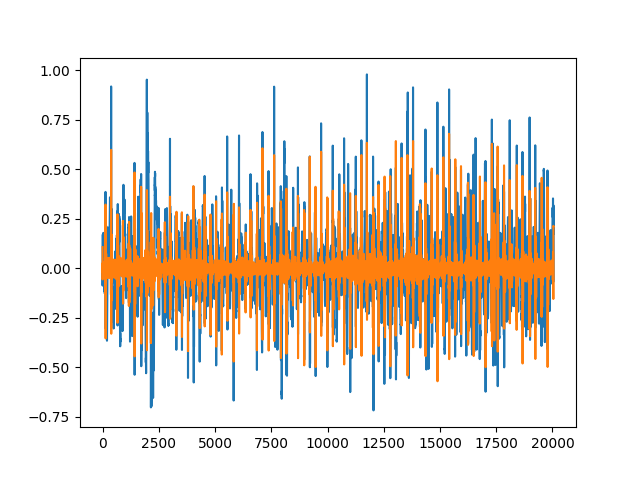

In [13]:
# Cargando el archivo de audio
audio, samplerate = sf.read(wav_files[1])

# Downsampling
new_rate, dwns_signal = downsampling_signal(audio, samplerate, 
                                            freq_pass=450, 
                                            freq_stop=500)

# Filtro pasa banda
audio_bp = bandpass_filter(dwns_signal, new_rate, 
                           freq_stop_1=20, freq_pass_1=40, 
                           freq_pass_2=200, freq_stop_2=220, 
                           bp_method='scipy_fir')

%matplotlib notebook
plt.plot(dwns_signal)
plt.plot(audio_bp)
plt.show()

# Envolventes

In [6]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
# db_ultimate = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]

In [20]:
# filename = 'normal__201105011626'
# file = f'Generated/normal_a/{filename}'
# audio, samplerate = sf.read(f'{file}.wav')

# samplerate, dwns_signal = downsampling_signal(audio, samplerate, 
#                                             freq_pass=450, 
#                                             freq_stop=500)

# audio_bp = bandpass_filter(dwns_signal, new_rate, 
#                            freq_stop_1=20, freq_pass_1=40, 
#                            freq_pass_2=200, freq_stop_2=220, 
#                            bp_method='scipy_fir', normalize=True)



# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[10])

# Se normaliza
audio = audio / max(abs(audio))

# Se filtra
audio_bp = bandpass_filter(audio, samplerate, 
                           freq_stop_1=20, freq_pass_1=30, 
                           freq_pass_2=180, freq_stop_2=200, 
                           bp_method='scipy_fir', normalize=True)

# Parámetros
N_env = 128
step_env = 16

homomorphic_dict = {'cutoff_freq': 10, 'delta_band': 5}
hilbert_dict = {'analytic_env': True, 'inst_phase': False, 'inst_freq': False}
simplicity_dict = None
vfd_dict = {'N': N_env, 'noverlap': N_env - step_env, 'kmin': 4, 'kmax': 4, 
            'step_size_method': 'unit', 'inverse': True}
wavelet_dict = {'wavelet': 'db4', 'levels': [3,4], 'start_level': 1, 'end_level': 4}
spec_track_dict = {'freq_obj': [100, 120], 'N': N_env, 'noverlap': N_env - step_env, 
                   'padding': 0, 'repeat': 0, 'window': 'hann'}
spec_energy_dict = {'band_limits': [30, 180], 'alpha': 1, 'N': N_env, 
                    'noverlap': N_env - step_env, 'padding': 0, 'repeat': 0 , 
                    'window': 'hann'}
append_fft = False

<IPython.core.display.Javascript object>


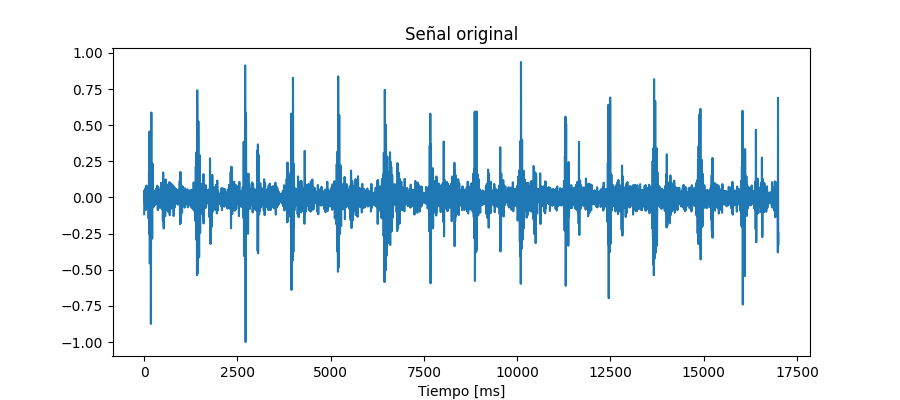

In [23]:
%matplotlib notebook
plt.figure(figsize=(9,4))
# plt.plot(audio)
plt.plot(audio_bp)
plt.title('Señal original')
plt.xlabel('Tiempo [ms]')
plt.show()

In [21]:
envelopes = get_envelope_pack(audio_bp, samplerate, homomorphic_dict=homomorphic_dict, 
                              hilbert_dict=hilbert_dict, simplicity_dict=simplicity_dict, 
                              vfd_dict=vfd_dict, wavelet_dict=wavelet_dict, 
                              spec_track_dict=spec_track_dict, spec_energy_dict=spec_energy_dict, 
                              norm_type='minmax')

print(envelopes.shape)

(17000, 7)


<IPython.core.display.Javascript object>


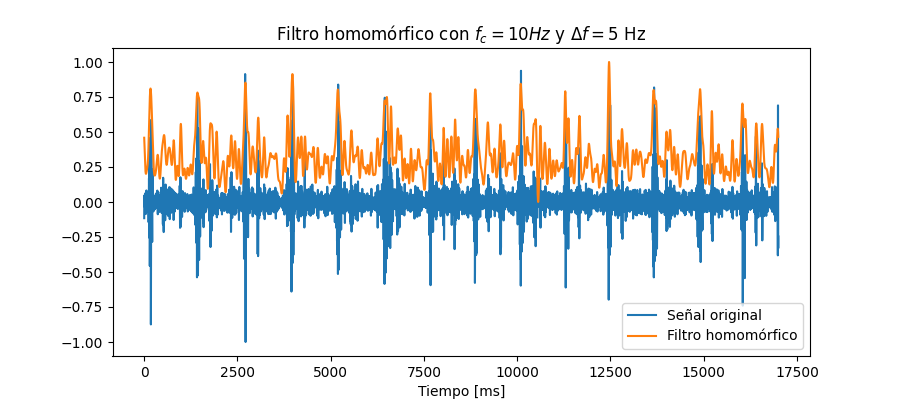

<IPython.core.display.Javascript object>


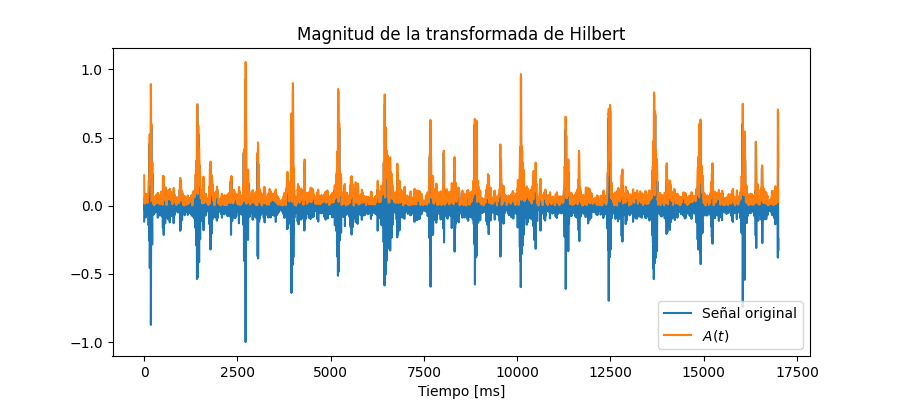

<IPython.core.display.Javascript object>


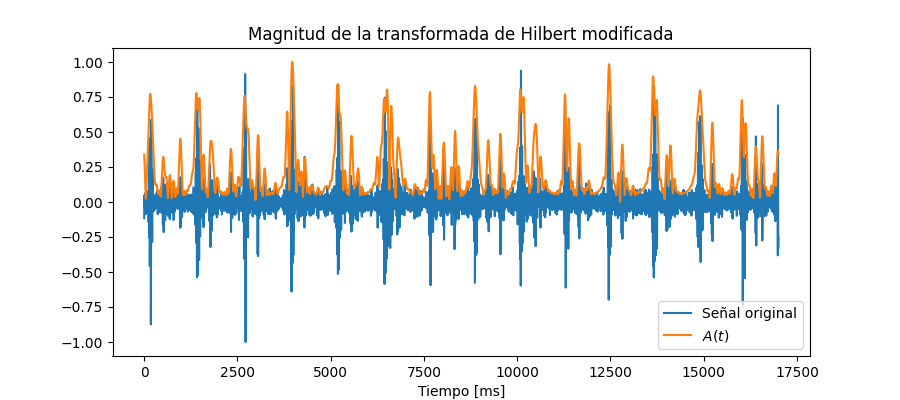

<IPython.core.display.Javascript object>


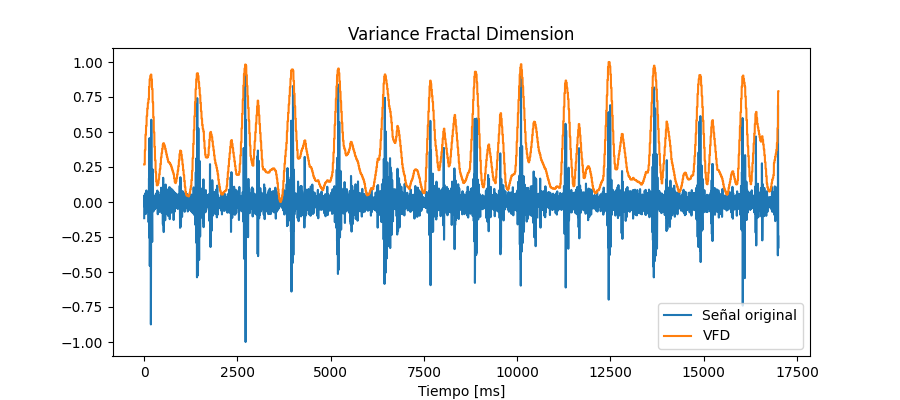

<IPython.core.display.Javascript object>


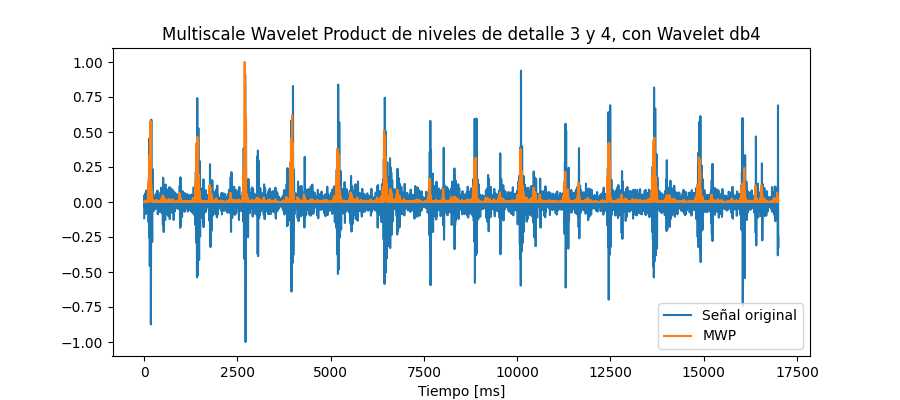

<IPython.core.display.Javascript object>


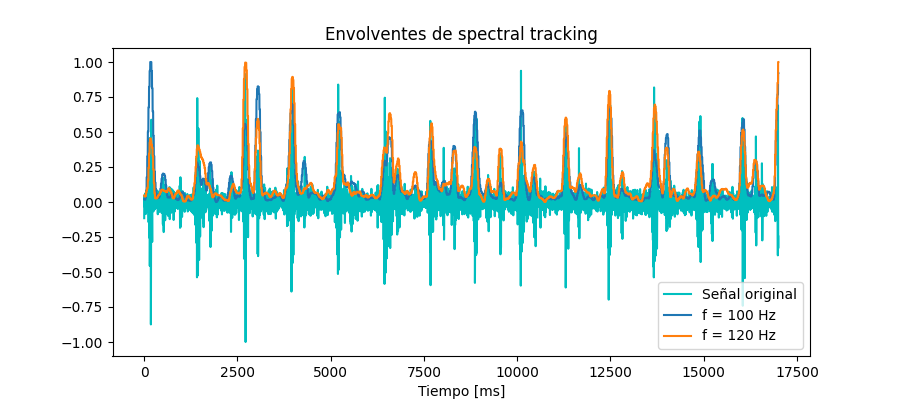

<IPython.core.display.Javascript object>


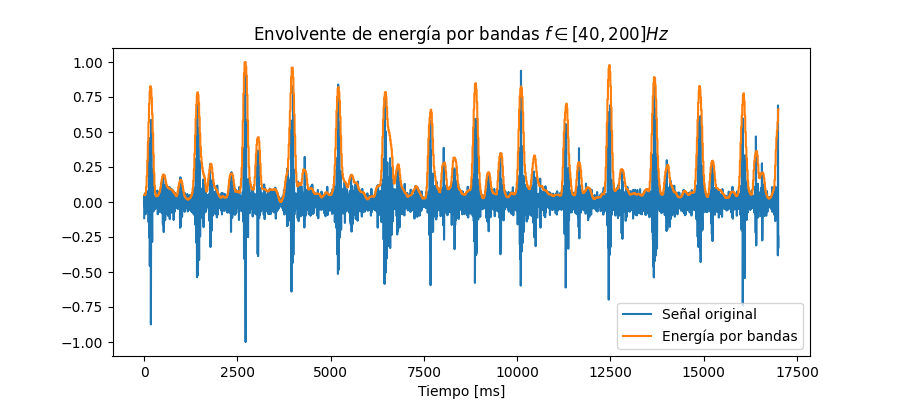

In [22]:
%matplotlib notebook
plt.figure(figsize=(9,4))
plt.plot(audio_bp, label='Señal original')
plt.plot(envelopes[:,0], label='Filtro homomórfico')
plt.title(r'Filtro homomórfico con $f_c = 10 Hz$ y $\Delta f = 5$ Hz')
plt.xlabel('Tiempo [ms]')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(9,4))
plt.plot(audio_bp, label='Señal original')
plt.plot(abs(hilbert_representation(audio_bp, samplerate)[0]), label=r'$A(t)$')
plt.title(r'Magnitud de la transformada de Hilbert')
plt.xlabel('Tiempo [ms]')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(9,4))
plt.plot(audio_bp, label='Señal original')
plt.plot(envelopes[:,1], label=r'$A(t)$')
plt.title(r'Magnitud de la transformada de Hilbert modificada')
plt.xlabel('Tiempo [ms]')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(9,4))
plt.plot(audio_bp, label='Señal original')
plt.plot(envelopes[:,2], label='VFD')
plt.title(r'Variance Fractal Dimension')
plt.xlabel('Tiempo [ms]')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(9,4))
plt.plot(audio_bp, label='Señal original')
plt.plot(envelopes[:,3], label='MWP')
plt.title(r'Multiscale Wavelet Product de niveles de detalle 3 y 4, con Wavelet db4')
plt.xlabel('Tiempo [ms]')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(9,4))
plt.plot(audio_bp, color='c', label='Señal original')
plt.plot(envelopes[:,4], label=f'f = {spec_track_dict["freq_obj"][0]} Hz')
plt.plot(envelopes[:,5], label=f'f = {spec_track_dict["freq_obj"][1]} Hz')
plt.title(r'Envolventes de spectral tracking')
plt.xlabel('Tiempo [ms]')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(9,4))
plt.plot(audio_bp, label='Señal original')
plt.plot(envelopes[:,6], label='Energía por bandas')
plt.title(r'Envolvente de energía por bandas $f \in [40, 200] Hz$')
plt.xlabel('Tiempo [ms]')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


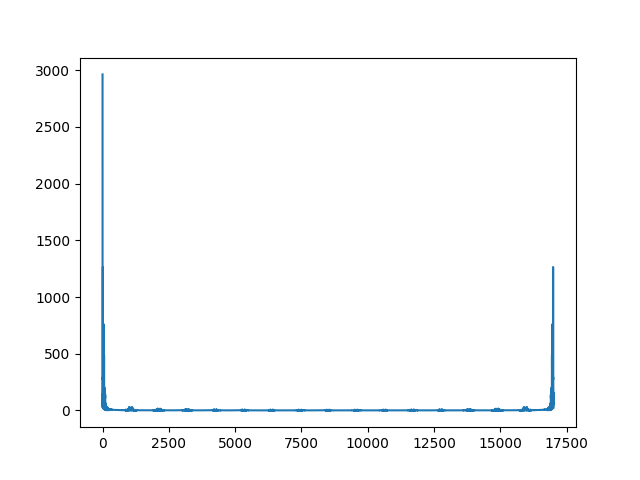

In [73]:
%matplotlib notebook
plt.plot(abs(np.fft.fft(envelopes[:,6])))
plt.show()

In [77]:
audio_bp[:8]

array([-0.05780483,  0.11750409,  0.16205222,  0.13164099,  0.109592  ,
        0.11848741,  0.12258491,  0.09420516])

# Ejemplo base de datos

<IPython.core.display.Javascript object>


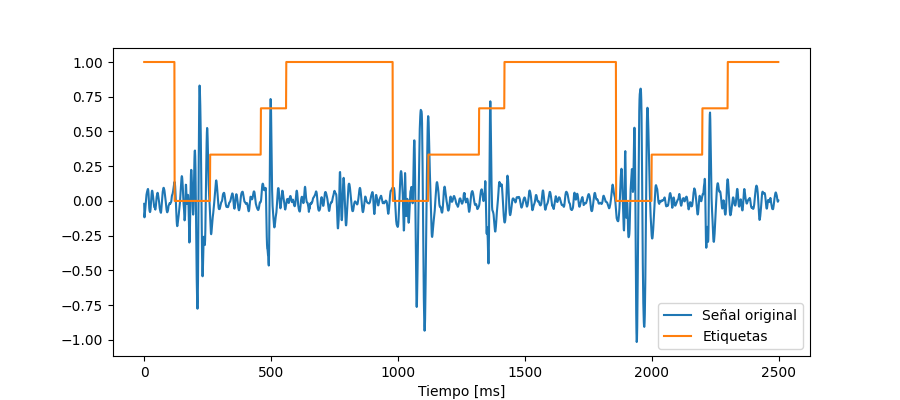

In [6]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]
label_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.mat')]

ind = 15

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[ind])

audio = audio / max(abs(audio))

# Cargando las etiquetas
data_info = loadmat(f'{label_files[ind]}')

# Etiquetas a 50 Hz de samplerate
labels = data_info['PCG_states']

# Pasando a 1000 Hz
labels_adj = np.repeat(labels, 20) - 1
labels_adj = labels_adj / max(abs(labels_adj))

%matplotlib notebook
plt.figure(figsize=(9,4))
plt.plot(audio, label='Señal original')
plt.plot(labels_adj, label='Etiquetas')
plt.legend(loc='lower right')
plt.xlabel('Tiempo [ms]')
plt.show()

[4 4 4 ... 4 4 4]


<IPython.core.display.Javascript object>


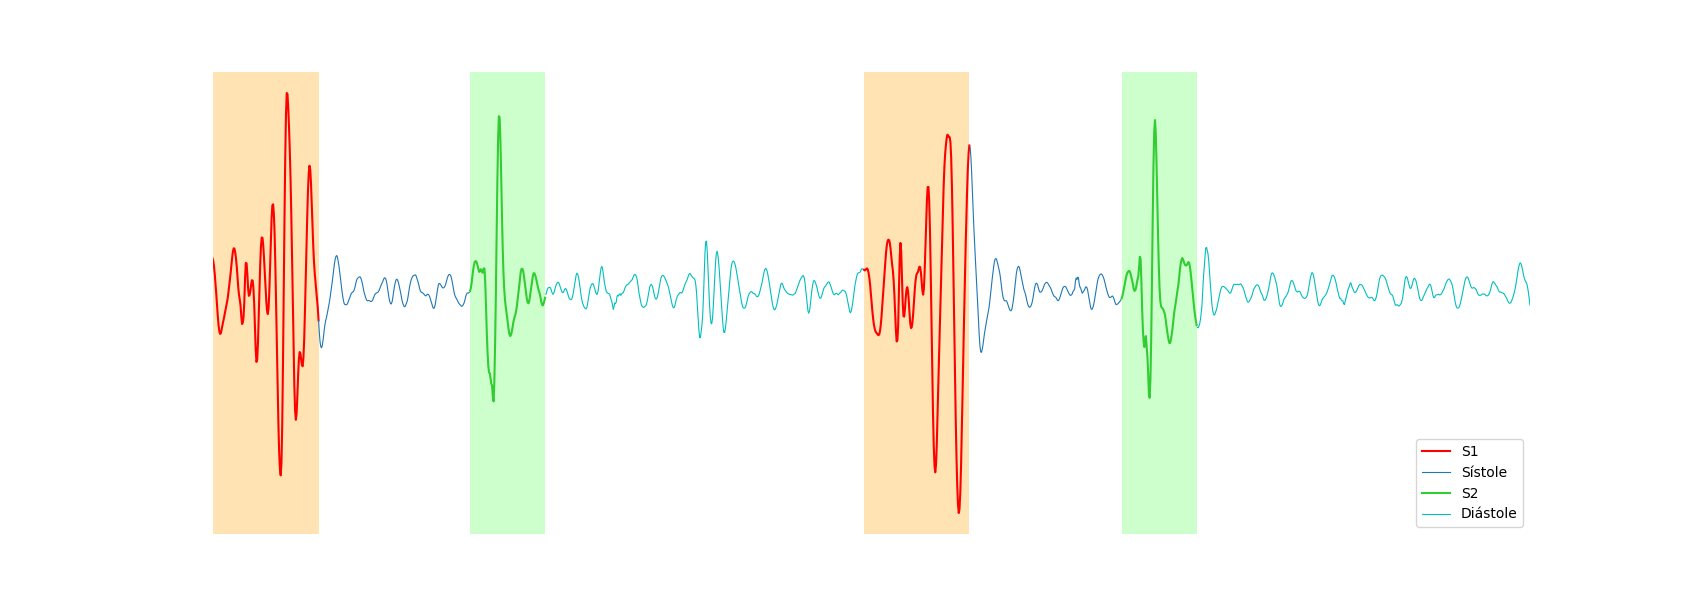

In [57]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]
label_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.mat')]

ind = 15

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[ind])
audio = audio / max(abs(audio))

# Cargando las etiquetas
data_info = loadmat(f'{label_files[ind]}')

# Etiquetas a 50 Hz de samplerate
labels = data_info['PCG_states']

# Pasando a 1000 Hz
labels_adj = np.repeat(labels, 20)
print(labels_adj)

# Obteniendo las posiciones de un ciclo
s1_pos = np.where(labels_adj == 1)
sy_pos = np.where(labels_adj == 2)
s2_pos = np.where(labels_adj == 3)
dy_pos = np.where(labels_adj == 4)


def get_segments(list_to_rev):
    # Definición de la lista del segmento
    segment_to = list()
    
    # Definición lista de salida
    list_out = list()
    
    # Generando listas de segmentos
    for i in range(len(list_to_rev) - 1):
        # Criterio para agregar
        if list_to_rev[i+1] - list_to_rev[i] == 1 and i < len(list_to_rev) - 2:
            segment_to.append(list_to_rev[i])

        else:
            segment_to.append(list_to_rev[i])

            # Agregando a la lista de segmentos
            list_out.append(segment_to)
            segment_to = list()
    
    return list_out
 

# Obteniendo la lista de los segmentos
s1_segm = get_segments(s1_pos[0])
sy_segm = get_segments(sy_pos[0])
s2_segm = get_segments(s2_pos[0])
dy_segm = get_segments(dy_pos[0])
    
s1_segm[0].append(s1_segm[0][-1]+1)
    
%matplotlib notebook
plt.figure(figsize=(17,6))
# plt.plot(audio[s1_segm[1][0]:dy_segm[2][-1]], label='Señal original')
plt.plot(s1_segm[0], audio[s1_segm[0]], 'r', label='S1')
plt.plot(sy_segm[0], audio[sy_segm[0]], 'C0', label='Sístole', lw=0.8)
plt.plot(s2_segm[0], audio[s2_segm[0]], 'limegreen', label='S2')
plt.plot(dy_segm[1], audio[dy_segm[1]], 'c', label='Diástole', lw=0.8)

plt.plot(s1_segm[1], audio[s1_segm[1]], 'r')
plt.plot(sy_segm[1], audio[sy_segm[1]], 'C0', lw=0.8)
plt.plot(s2_segm[1], audio[s2_segm[1]], 'limegreen')
plt.plot(dy_segm[2], audio[dy_segm[2]], 'c', lw=0.8)

plt.axvspan(s1_segm[0][0], s1_segm[0][-1], facecolor='orange', alpha=0.3)
plt.axvspan(s2_segm[0][0], s2_segm[0][-1], facecolor='lime', alpha=0.2)
plt.axvspan(s1_segm[1][0], s1_segm[1][-1], facecolor='orange', alpha=0.3)
plt.axvspan(s2_segm[1][0], s2_segm[1][-1], facecolor='lime', alpha=0.2)

# plt.plot(labels_adj, label='Etiquetas')
# plt.tick_params(left=False, labelleft=False)
plt.axis('off')
plt.xlim([s1_segm[0][0], dy_segm[2][-1]])
# plt.title('Señal de fonocardiograma')
plt.legend(loc='lower right')
plt.xlabel('Tiempo [ms]')
plt.show()

# Ventana inversa

<IPython.core.display.Javascript object>


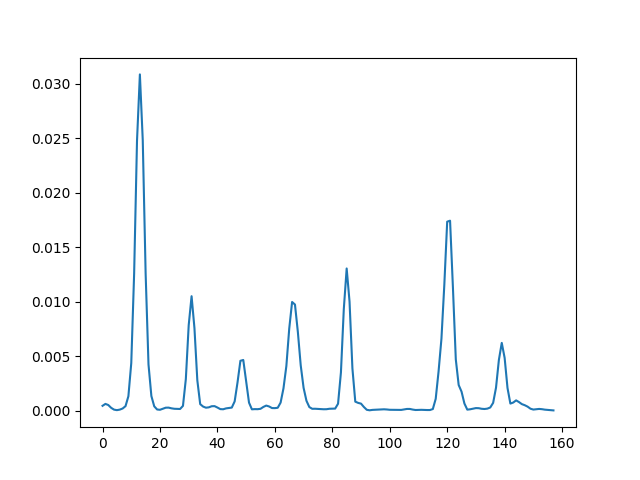

In [22]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[15])

audio = audio / max(abs(audio))


s_out = spectral_energy_bands(audio, samplerate, band_limits=[50, 200], alpha=2,
                              N=128,  noverlap=128-16, padding=0, repeat=0, 
                              window='hann')

%matplotlib notebook
plt.plot(s_out)
plt.show()

<IPython.core.display.Javascript object>


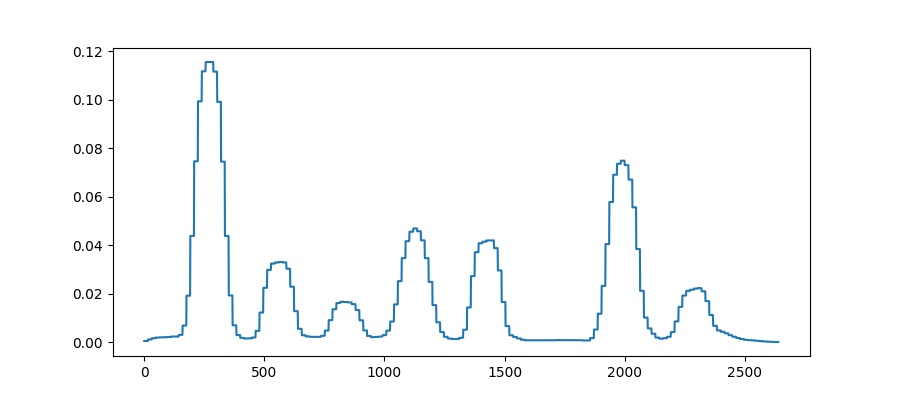

array([4.47389146e-04, 4.47389146e-04, 4.47389146e-04, ...,
       2.59754058e-05, 2.59754058e-05, 2.59754058e-05])

In [46]:
def get_inverse_windowed_signal(signal_in, N, noverlap):
    '''Función que permite obtener la representación original de una 
    señal a partir de una matriz de señal ventaneada.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada a transformar. Puede tener más de un canal (por 
        ejemplo: audio, wavelets, shannon, etc.)
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la 
        matriz. Por defecto es 0.
        
    Returns
    -------
    signal_out : ndarray
        Reconstrucción a partir de una señal ventaneada.
    '''
    # A partir del overlap, el tamaño de cada ventana y la cantidad de frames 
    # a las que se les ventanea, se define la cantidad de muestras que 
    # representa la señal original
    step = N - noverlap                               # Tamaño del paso
    total_samples = step * (len(signal_in) - 1) + N   # Tamaño total del arreglo
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_wind = np.zeros(total_samples, dtype=np.float)
    
    # Definición de una lista de suma de ventanas cuadráticas en el tiempo
    sum_wind = np.zeros(total_samples, dtype=np.float)
    
    # Transformando punto a punto (nótese la división en tiempo por una 
    # ventana definida)
    for i, sample in enumerate(signal_in):
        # Definición del punto inicial
        beg = i * step
        # Se agrega una ventana de "N" puntos con valor "sample"
        inv_wind[beg:beg+N] += sample
        
        # Se agrega una ventana de "N" puntos con valor 1 que permitirá 
        # corregir por los valores de traslape
        sum_wind[beg:beg+N] += 1
    
    %matplotlib notebook
    plt.figure(figsize=(9,4))
    plt.plot(inv_wind)
    # plt.plot(sum_wind)
    plt.show()
    
    return np.divide(inv_wind, sum_wind)


get_inverse_windowed_signal(s_out, N=128, noverlap=128-16)

<IPython.core.display.Javascript object>


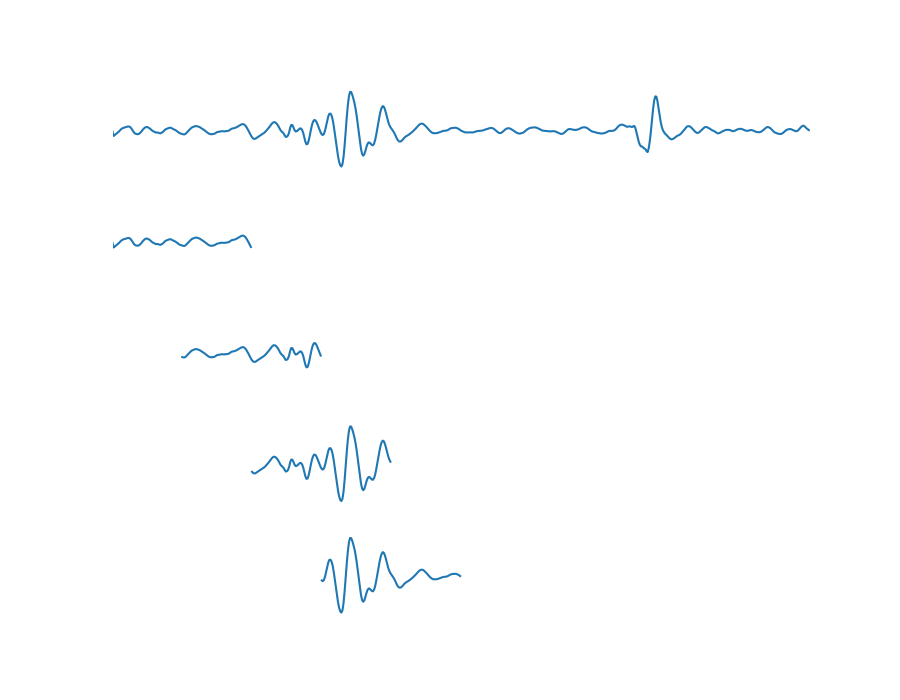

In [42]:
%matplotlib notebook
N = 128
nov = 64

x1 = np.arange(int(0 * nov), int(0 * nov + N))
x2 = np.arange(int(1 * nov), int(1 * nov + N))
x3 = np.arange(int(2 * nov), int(2 * nov + N))
x4 = np.arange(int(3 * nov), int(3 * nov + N))

plt.figure(figsize=(9,7))
plt.subplot(5,1,1)
plt.plot(audio[:N * 5])
plt.xlim([0, N * 5])
plt.ylim([-1,1])
plt.axis('off')

plt.subplot(5,1,2)
plt.plot(x1,  audio[x1])
# plt.plot(x1,  max(audio[x1]))
plt.xlim([0, N * 5])
plt.ylim([-1,1])
plt.axis('off')

plt.subplot(5,1,3)
plt.plot(x2,  audio[x2])
# plt.plot(x2,  max(audio[x2]))
plt.xlim([0, N * 5])
plt.ylim([-1,1])
plt.axis('off')

plt.subplot(5,1,4)
plt.plot(x3,  audio[x3])
# plt.plot(x3,  max(audio[x3]))
plt.xlim([0, N * 5])
plt.ylim([-1,1])
plt.axis('off')

plt.subplot(5,1,5)
plt.plot(x4,  audio[x4])
# plt.plot(x4,  max(audio[x4]))
plt.xlim([0, N * 5])
plt.ylim([-1,1])
plt.axis('off')

plt.show()

<IPython.core.display.Javascript object>


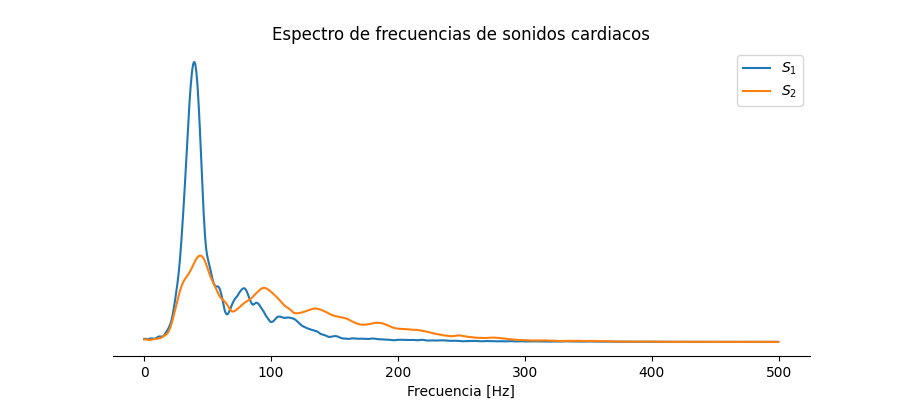

In [78]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]
label_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.mat')]

ind = 12

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[ind])

audio = audio / max(abs(audio))

# Cargando las etiquetas
data_info = loadmat(f'{label_files[ind]}')

# Etiquetas a 50 Hz de samplerate
labels = data_info['PCG_states']

# Pasando a 1000 Hz
labels_adj = np.repeat(labels, 20)

# Obteniendo las posiciones de un ciclo
s1_pos = np.where(labels_adj == 1)[0]
sy_pos = np.where(labels_adj == 2)[0]
s2_pos = np.where(labels_adj == 3)[0]
dy_pos = np.where(labels_adj == 4)[0]

def get_segments(list_to_rev):
    # Definición de la lista del segmento
    segment_to = list()
    
    # Definición lista de salida
    list_out = list()
    
    # Generando listas de segmentos
    for i in range(len(list_to_rev) - 1):
        # Criterio para agregar
        if list_to_rev[i+1] - list_to_rev[i] == 1 and i < len(list_to_rev) - 2:
            segment_to.append(list_to_rev[i])

        else:
            segment_to.append(list_to_rev[i])

            # Agregando a la lista de segmentos
            list_out.append(segment_to)
            segment_to = list()
    
    return list_out

# Obteniendo una PSD a partir de cada segmento
s1_seg = get_segments(s1_pos)
s2_seg = get_segments(s2_pos)

# Cantidad de puntos extra a considerar para obtener el espectro
delta_f = 10

# Cantidad de puntos por espectro
N = 2048

# Definición del arreglo que guardará las FFT
fft_array_s1 = np.zeros((N, 0))
fft_array_s2 = np.zeros((N, 0))

for seg in s1_seg:
    # Segmento de audio
    audio_seg = audio[seg[0] - delta_f:seg[-1] + delta_f]
    
    # Calculando la transformada de fourier
    audio_fft = abs(np.fft.fft(audio_seg, n=N))
    
    # Agregando una dimensión
    audio_fft = np.expand_dims(audio_fft, -1)
    
    # Agregando al arreglo
    fft_array_s1 = np.concatenate((fft_array_s1, audio_fft), axis=-1)


for seg in s2_seg:
    # Segmento de audio
    audio_seg = audio[seg[0] - delta_f:seg[-1] + delta_f]
    
    # Calculando la transformada de fourier
    audio_fft = abs(np.fft.fft(audio_seg, n=N))
    
    # Agregando una dimensión
    audio_fft = np.expand_dims(audio_fft, -1)
    
    # Agregando al arreglo
    fft_array_s2 = np.concatenate((fft_array_s2, audio_fft), axis=-1)
    
# Obtener la psd del S1
psd_s1 = fft_array_s1.mean(axis=1)[:N//2]
psd_s2 = fft_array_s2.mean(axis=1)[:N//2]

# Definición del eje de las frecuencias
f = np.linspace(0, 1000, N)
f = f[:N//2]

%matplotlib notebook
plt.figure(figsize=(9,4))
plt.plot(f, psd_s1, label=r'$S_1$')
plt.plot(f, psd_s2, label=r'$S_2$')
plt.legend(loc='upper right')
plt.xlabel('Frecuencia [Hz]')
plt.title(r'Espectro de frecuencias de sonidos cardiacos')
plt.tick_params(left=False, labelleft=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

# Etiquetas de sonido cardiaco

[120, 260, 460, 560, 980, 1120, 1320, 1420, 1860, 2000, 2200, 2300]


<IPython.core.display.Javascript object>


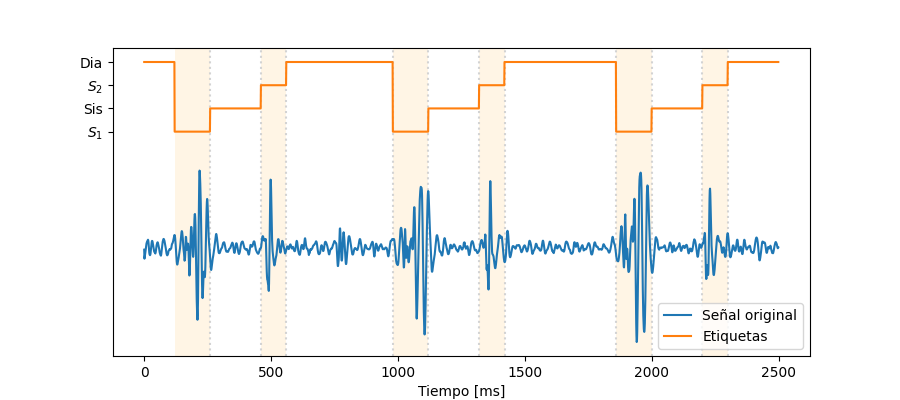

In [85]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]
label_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.mat')]

ind = 15

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[ind])

audio = audio / max(abs(audio))

# Cargando las etiquetas
data_info = loadmat(f'{label_files[ind]}')

# Etiquetas a 50 Hz de samplerate
labels = data_info['PCG_states']

# Pasando a 1000 Hz
labels_adj = np.repeat(labels, 20)
labels_adj_to = labels_adj / max(abs(labels_adj)) + 1

# Obteniendo los puntos en donde se ubican los límites de los sonidos cardiacos
limit_pos = [num for num, i in enumerate(labels_adj) 
             if True in [(i == 1) and (labels_adj[num-1] == 4),
                         i == 2 and labels_adj[num-1] == 1,
                         i == 3 and labels_adj[num-1] == 2,
                         i == 4 and labels_adj[num-1] == 3]]

print(limit_pos)

%matplotlib notebook
plt.figure(figsize=(9,4))
for num, i in enumerate(limit_pos[1:]):
    plt.axvline(i, linestyle=':', color='lightgray')
    if num % 2 == 0 and not (num == len(limit_pos) - 1):
        plt.axvspan(limit_pos[num], limit_pos[num+1], facecolor='orange', alpha=0.1)
plt.plot(audio, label='Señal original')
plt.plot(labels_adj_to, label='Etiquetas', color='C1')
plt.legend(loc='lower right')
plt.xlabel('Tiempo [ms]')
plt.yticks([1.25, 1.5, 1.75, 2], [r'$S_1$', 'Sis', r'$S_2$', 'Dia'])

plt.savefig('Images/Database_sound_and_labels.pdf', transparent=True)
plt.show()

# Función de threshold

<IPython.core.display.Javascript object>


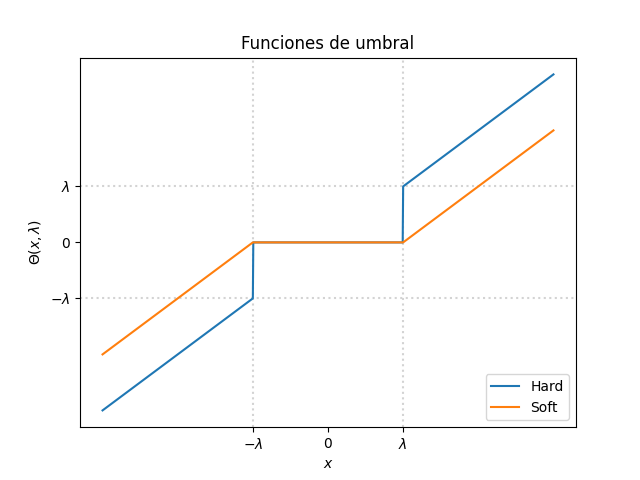

In [8]:
s = np.linspace(-1.5,1.5, 1000)
lambda_val = 0.5

s_soft = pywt.threshold(s, value=lambda_val, mode='soft')
s_hard = pywt.threshold(s, value=lambda_val, mode='hard')

%matplotlib notebook
plt.axvline(lambda_val, linestyle=':', color='lightgray')
plt.axvline(-lambda_val, linestyle=':', color='lightgray')
plt.axhline(lambda_val, linestyle=':', color='lightgray')
plt.axhline(-lambda_val, linestyle=':', color='lightgray')
plt.plot(s, s_hard, label='Hard')
plt.plot(s, s_soft, label='Soft')

plt.legend(loc='lower right')
plt.title('Funciones de umbral')
plt.xlabel(r'$x$')
plt.ylabel(r'$\Theta(x, \lambda)$')

# Seteando los ticks
plt.xticks(ticks=[-0.5, 0, 0.5], labels=[r'$-\lambda$', '0', r'$\lambda$'])
plt.yticks(ticks=[-0.5, 0, 0.5], labels=[r'$-\lambda$', '0', r'$\lambda$'])

# Guardando
plt.savefig('Images/Threshold_funcs.pdf')

plt.show()

# Etiquetas de sonido cardiaco conjunta

<IPython.core.display.Javascript object>


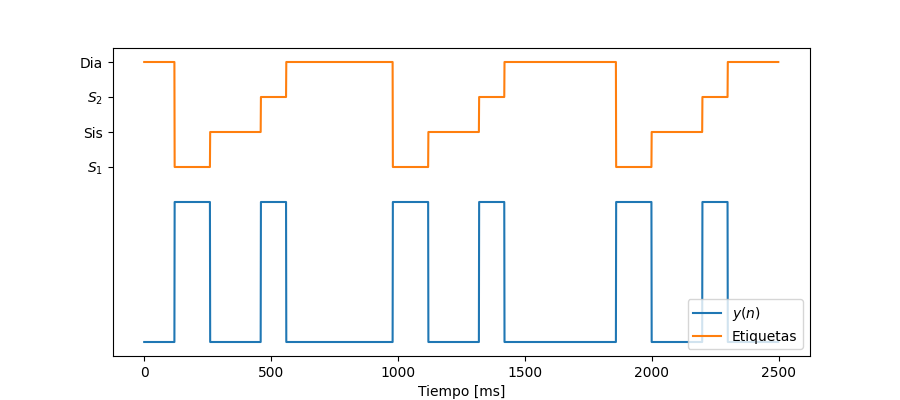

In [12]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]
label_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.mat')]

ind = 15

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[ind])

audio = audio / max(abs(audio))

# Cargando las etiquetas
data_info = loadmat(f'{label_files[ind]}')

# Etiquetas a 50 Hz de samplerate
labels = data_info['PCG_states']

# Pasando a 1000 Hz
labels_adj = np.repeat(labels, 20)
labels_adj_to = labels_adj / max(abs(labels_adj)) + 1

# Definición de la posición de los sonidos cardiacos
heart_sound_pos = (labels_adj == 1) + (labels_adj == 3)

%matplotlib notebook
plt.figure(figsize=(9,4))
plt.plot(heart_sound_pos, label=r'$y(n)$')
plt.plot(labels_adj_to, label='Etiquetas')
plt.legend(loc='lower right')
plt.xlabel('Tiempo [ms]')
plt.yticks([1.25, 1.5, 1.75, 2], [r'$S_1$', 'Sis', r'$S_2$', 'Dia'])

plt.savefig('Images/Heart_sound_pos.pdf')
plt.show()

# Función de resampling

<IPython.core.display.Javascript object>


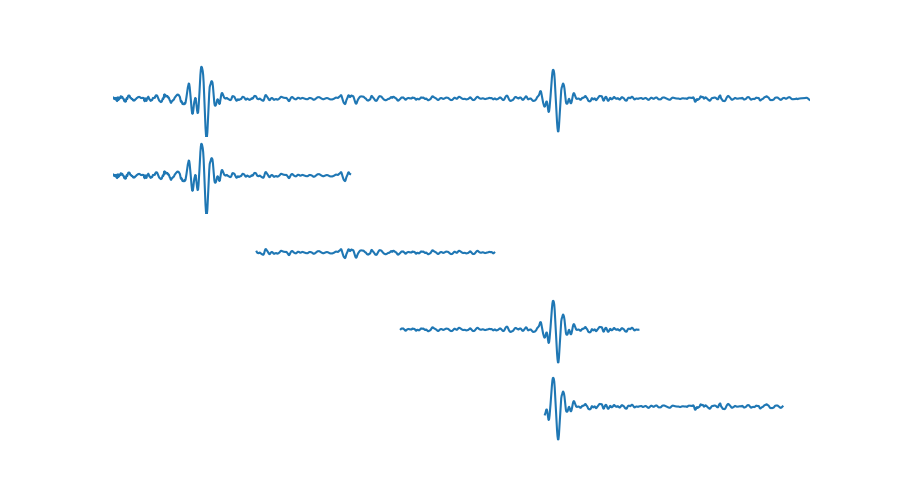

In [57]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[125])

audio = audio / max(abs(audio))

%matplotlib notebook
fig, axs = plt.subplots(3, 1, figsize=(9,5), sharex=True, frameon=True)

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

N = 512
step = 310
times = 5

limit_len = N * times if (N * times) < len(audio) else len(audio)

x1 = np.arange(int(0 * step), int(0 * step + N))
x2 = np.arange(int(1 * step), int(1 * step + N))
x3 = np.arange(int(2 * step), int(2 * step + N))
x4 = np.arange(int(3 * step), int(3 * step + N))

plt.margins(0,0)
# plt.figure(figsize=(9,7))
plt.subplot(5,1,1)
plt.plot(audio[:limit_len])
plt.xlim([0, limit_len])
plt.ylim([-1,1])
plt.axis('off')

plt.subplot(5,1,2)
plt.plot(x1,  audio[x1])
# plt.plot(x1,  max(audio[x1]))
plt.xlim([0, limit_len])
plt.ylim([-1,1])
plt.axis('off')

plt.subplot(5,1,3)
plt.plot(x2,  audio[x2])
# plt.plot(x2,  max(audio[x2]))
plt.xlim([0, limit_len])
plt.ylim([-1,1])
plt.axis('off')

plt.subplot(5,1,4)
plt.plot(x3,  audio[x3])
# plt.plot(x3,  max(audio[x3]))
plt.xlim([0, limit_len])
plt.ylim([-1,1])
plt.axis('off')

plt.subplot(5,1,5)
plt.plot(x4,  audio[x4])
# plt.plot(x4,  max(audio[x4]))
plt.xlim([0, limit_len])
plt.ylim([-1,1])
plt.axis('off')

plt.savefig('Images/Resample_1.svg', transparent=True, bbox_inches='tight')
plt.show()

# Gráfico de PCG multiscale wavelet product

<IPython.core.display.Javascript object>


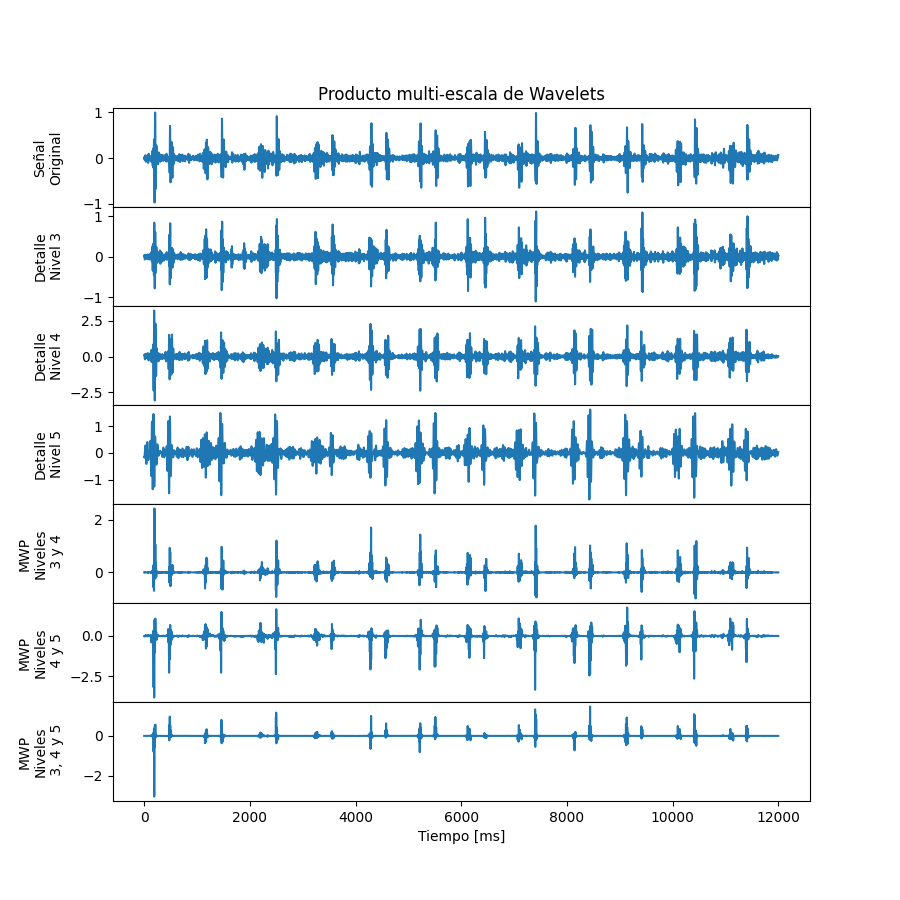

In [51]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[100])

# Normalizando
audio = audio / max(abs(audio))

# Definición de los niveles de interés
levels = [3,4,5]
wav_coeffs = stationary_wavelets_decomposition(audio, wavelet='db6', levels=levels,
                                               start_level=0, end_level=5, erase_pad=True)

%matplotlib notebook
fig, axs = plt.subplots(7, 1, figsize=(9,9), sharex=True, frameon=True)

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
axs[0].plot(audio)
axs[0].set_ylabel('Señal\nOriginal')
axs[0].set_title('Producto multi-escala de Wavelets')

axs[1].plot(wav_coeffs[:, 0])
axs[1].set_ylabel(f'Detalle\nNivel {levels[0]}')

axs[2].plot(wav_coeffs[:, 1])
axs[2].set_ylabel(f'Detalle\nNivel {levels[1]}')

axs[3].plot(wav_coeffs[:, 2])
axs[3].set_ylabel(f'Detalle\nNivel {levels[2]}')

axs[4].plot(wav_coeffs[:, 0] * wav_coeffs[:, 1])
axs[4].set_ylabel(f'MWP\nNiveles\n {levels[0]} y {levels[1]}')

axs[5].plot(wav_coeffs[:, 1] * wav_coeffs[:, 2])
axs[5].set_ylabel(f'MWP\nNiveles\n {levels[1]} y {levels[2]}')

axs[6].plot(wav_coeffs[:, 0] * wav_coeffs[:, 1] * wav_coeffs[:, 2])
axs[6].set_ylabel(f'MWP\nNiveles\n {levels[0]}, {levels[1]} y {levels[2]}')

fig.align_ylabels(axs[:])
plt.xlabel('Tiempo [ms]')
plt.savefig('Images/Multiscale_Wav_Prod.pdf', transparent=True)
plt.show()

# Gráfico de envolventes

In [6]:
# Obtención de los archivos de testeo
heart_db = 'PhysioNet 2016 CINC Heart Sound Database'
# db_ultimate = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{heart_db}/{i}' for i in os.listdir(heart_db) if i.endswith('.wav')]

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[15])

# Se normaliza
audio = audio / max(abs(audio))

# Se filtra
audio_bp = bandpass_filter(audio, samplerate, 
                           freq_stop_1=20, freq_pass_1=30, 
                           freq_pass_2=180, freq_stop_2=200, 
                           bp_method='scipy_fir', normalize=True)

# Parámetros
N_env_vfd = 64
step_env_vfd = 8
N_env_spec = 64
step_env_spec = 8
N_env_energy = 128
step_env_energy = 16

# Diccionarios
homomorphic_dict = {'cutoff_freq': 10, 'delta_band': 5}
hilbert_dict = {'analytic_env': True, 'analytic_env_mod': True, 
                'inst_phase': False, 'inst_freq': False}
simplicity_dict = None
vfd_dict = {'N': N_env_vfd, 'noverlap': N_env_vfd - step_env_vfd, 'kmin': 4, 'kmax': 4, 
            'step_size_method': 'unit', 'inverse': True}
multiscale_wavelet_dict = {'wavelet': 'db6', 'levels': [3,4], 'start_level': 0, 'end_level': 4}
spec_track_dict =  {'freq_obj': [40, 60], 'N': N_env_spec, 'noverlap': N_env_spec - step_env_spec, 
                    'padding': 0, 'repeat': 0, 'window': 'hann'}
spec_energy_dict = {'band_limits': [30, 120], 'alpha': 1, 'N': N_env_energy, 
                    'noverlap': N_env_energy - step_env_energy, 'padding': 0, 'repeat': 0 , 
                    'window': 'hann'}
wavelet_dict = {'wavelet': 'db6', 'levels': [4], 'start_level': 0, 'end_level': 4}


envelopes = get_envelope_pack(audio_bp, samplerate, homomorphic_dict=homomorphic_dict, 
                              hilbert_dict=hilbert_dict, simplicity_dict=simplicity_dict, 
                              vfd_dict=vfd_dict, 
                              multiscale_wavelet_dict=multiscale_wavelet_dict, 
                              spec_track_dict=spec_track_dict, 
                              spec_energy_dict=spec_energy_dict, 
                              wavelet_dict=wavelet_dict, 
                              norm_type='minmax')

print(envelopes.shape)

(2500, 9)


<IPython.core.display.Javascript object>


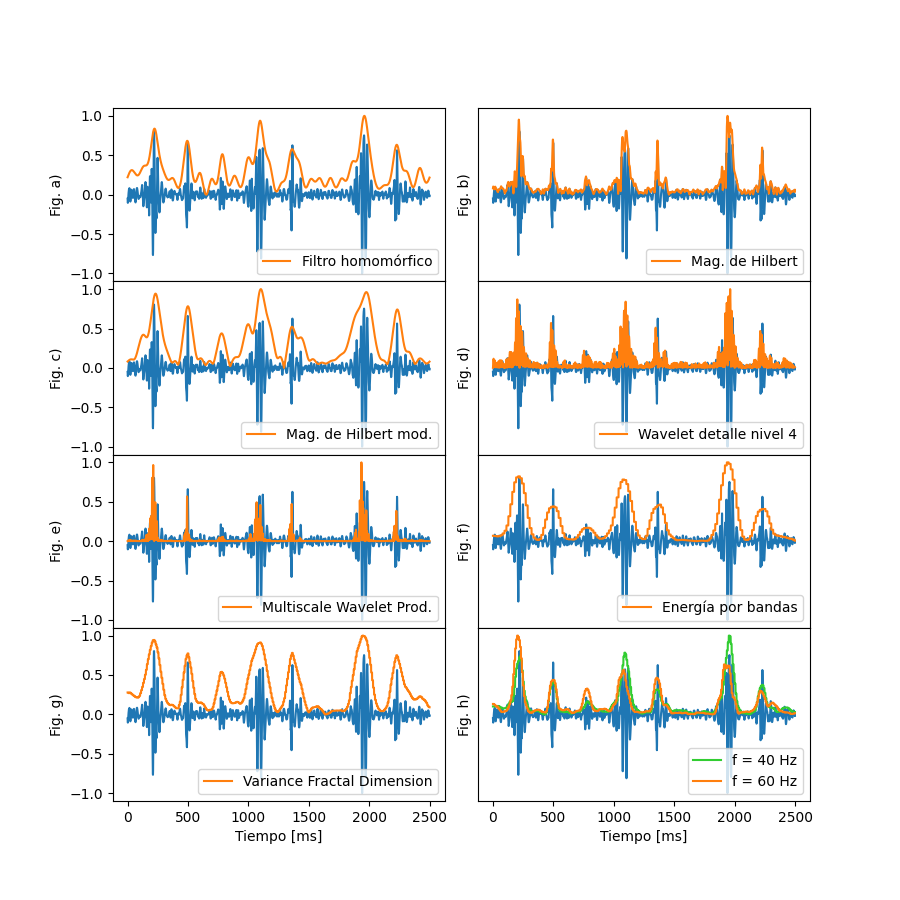

In [7]:
%matplotlib notebook
fig, axs = plt.subplots(4, 2, figsize=(9,9), sharex=True, frameon=True)

axs[0][0].plot(audio_bp)#, label='Señal original')
axs[0][0].plot(envelopes[:,0], label='Filtro homomórfico')
axs[0][0].set_ylabel('Fig. a)')
axs[0][0].legend(loc='lower right')

axs[0][1].plot(audio_bp)#, label='Señal original')
axs[0][1].plot(envelopes[:,1], label=r'Mag. de Hilbert')
axs[0][1].set_yticks([])
axs[0][1].set_ylabel('Fig. b)')
axs[0][1].legend(loc='lower right')

axs[1][0].plot(audio_bp)#, label='Señal original')
axs[1][0].plot(envelopes[:,2], label=r'Mag. de Hilbert mod.')
axs[1][0].set_ylabel('Fig. c)')
axs[1][0].legend(loc='lower right')

axs[1][1].plot(audio_bp)#, label='Señal original')
axs[1][1].plot(envelopes[:,8], label='Wavelet detalle nivel 4')
axs[1][1].set_yticks([])
axs[1][1].set_ylabel('Fig. d)')
axs[1][1].legend(loc='lower right')

axs[2][0].plot(audio_bp)#, label='Señal original')
axs[2][0].plot(envelopes[:,4], label='Multiscale Wavelet Prod.')
axs[2][0].set_ylabel('Fig. e)')
axs[2][0].legend(loc='lower right')

axs[2][1].plot(audio_bp)#, label='Señal original')
axs[2][1].plot(envelopes[:,7], label='Energía por bandas')
axs[2][1].set_ylabel('Fig. f)')
axs[2][1].set_yticks([])
axs[2][1].legend(loc='lower right')

axs[3][0].plot(audio_bp)#, label='Señal original')
axs[3][0].plot(envelopes[:,3], label='Variance Fractal Dimension')
axs[3][0].set_ylabel('Fig. g)')
axs[3][0].legend(loc='lower right')

axs[3][1].plot(audio_bp)
axs[3][1].plot(envelopes[:,5], color='limegreen', label=f'f = {spec_track_dict["freq_obj"][0]} Hz')
axs[3][1].plot(envelopes[:,6], color='C1', label=f'f = {spec_track_dict["freq_obj"][1]} Hz')
axs[3][1].set_yticks([])
axs[3][1].set_ylabel('Fig. h)')
axs[3][1].legend(loc='lower right')

axs[3][0].set_xlabel('Tiempo [ms]')
axs[3][1].set_xlabel('Tiempo [ms]')

# Remove horizontal space between axes
fig.subplots_adjust(wspace=0.1, hspace=0)

plt.savefig('Images/Descriptors_PCG.pdf')
plt.show()

<IPython.core.display.Javascript object>


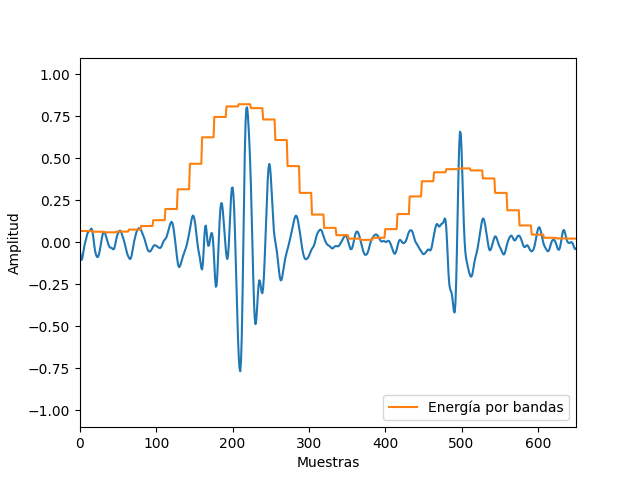

In [34]:
%matplotlib notebook
plt.plot(audio_bp)#, label='Señal original')
plt.plot(envelopes[:,7], label='Energía por bandas')
plt.ylabel('Amplitud')
plt.legend(loc='lower right')
plt.xlim([0,650])
plt.xlabel('Muestras')
plt.savefig('Images/Zoom_resampling.pdf')
plt.show()

# Funciones de activación

<IPython.core.display.Javascript object>


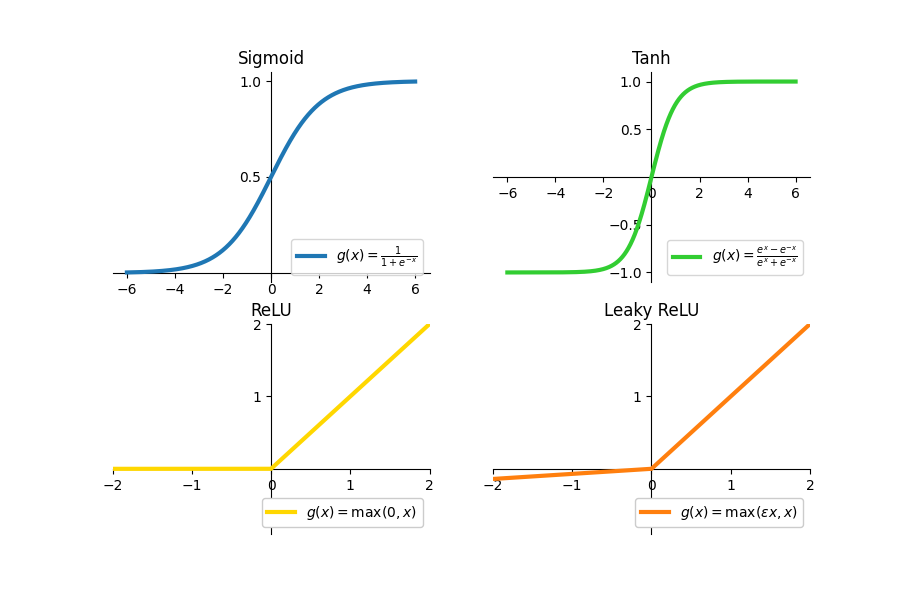

In [102]:
%matplotlib notebook
# Definición del rango x
x = np.linspace(-6, 6, 10000)
epsilon = 0.07

# Activaciones
sigmoid = 1 / (1 + np.exp(-x))
tanh = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
relu = [max(0, i) for i in x]
leaky_relu = [max(epsilon*i, i) for i in x]

fig, axs = plt.subplots(2, 2, figsize=(9,6))

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
axs[0][0].spines['left'].set_position('center')
axs[0][0].spines['bottom'].set_position('zero')
# Eliminate upper and right axes
axs[0][0].spines['right'].set_color('none')
axs[0][0].spines['top'].set_color('none')
for k, spine in axs[0][0].spines.items():  #ax.spines is a dictionary
    spine.set_zorder(0)
# Show ticks in the left and lower axes only
axs[0][0].xaxis.set_ticks_position('bottom')
axs[0][0].yaxis.set_ticks_position('left')
axs[0][0].plot(x, sigmoid, linewidth=3, label=r'$g(x) = \frac{1}{1 + e^{-x}}$')
axs[0][0].set_yticks([0.5, 1])
axs[0][0].legend(loc='lower right')
axs[0][0].set_title('Sigmoid')

axs[0][1].spines['left'].set_position('center')
axs[0][1].spines['bottom'].set_position('zero')
# Eliminate upper and right axes
axs[0][1].spines['right'].set_color('none')
axs[0][1].spines['top'].set_color('none')
for k, spine in axs[0][1].spines.items():  #ax.spines is a dictionary
    spine.set_zorder(0)
# Show ticks in the left and lower axes only
axs[0][1].xaxis.set_ticks_position('bottom')
axs[0][1].yaxis.set_ticks_position('left')
axs[0][1].plot(x, tanh, linewidth=3, color='limegreen', label=r'$g(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$')
axs[0][1].set_yticks([-1, -0.5, 0.5, 1])
axs[0][1].legend(loc='lower right')
axs[0][1].set_title('Tanh')

axs[1][0].spines['left'].set_position('center')
axs[1][0].spines['bottom'].set_position('zero')
# Eliminate upper and right axes
axs[1][0].spines['right'].set_color('none')
axs[1][0].spines['top'].set_color('none')
for k, spine in axs[1][0].spines.items():  #ax.spines is a dictionary
    spine.set_zorder(0)
# Show ticks in the left and lower axes only
axs[1][0].xaxis.set_ticks_position('bottom')
axs[1][0].yaxis.set_ticks_position('left')
axs[1][0].plot(x, relu, color='gold', linewidth=3, label=r'$g(x) = \max(0, x)$')
axs[1][0].set_yticks([1, 2])
axs[1][0].legend(loc='lower right', framealpha=1)
axs[1][0].set_title('ReLU')
axs[1][0].set_xlim([-2,2])
axs[1][0].set_ylim([-0.9,2])

axs[1][1].spines['left'].set_position('center')
axs[1][1].spines['bottom'].set_position('zero')
# Eliminate upper and right axes
axs[1][1].spines['right'].set_color('none')
axs[1][1].spines['top'].set_color('none')
for k, spine in axs[1][1].spines.items():  #ax.spines is a dictionary
    spine.set_zorder(0)
# Show ticks in the left and lower axes only
axs[1][1].xaxis.set_ticks_position('bottom')
axs[1][1].yaxis.set_ticks_position('left')
axs[1][1].plot(x, leaky_relu, color='C1', linewidth=3, label=r'$g(x) = \max(\epsilon x, x)$')
axs[1][1].set_yticks([1, 2])
axs[1][1].legend(loc='lower right', framealpha=1)
axs[1][1].set_title('Leaky ReLU')
axs[1][1].set_xlim([-2,2])
axs[1][1].set_ylim([-0.9,2])

plt.savefig('Images/Activation_functions.pdf', transparent=True)
plt.show()

# Obtener envolventes sin axis

<IPython.core.display.Javascript object>


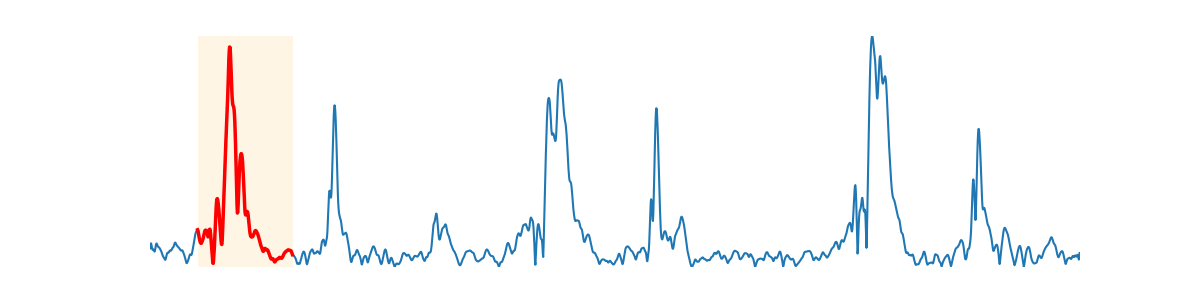

In [22]:
%matplotlib notebook
plt.figure(figsize=(12,3))
plt.plot(envelopes[:,1], label=r'Mag. de Hilbert')
plt.plot(np.arange(128, 128+256), envelopes[:,1][128:128+256], color='r', linewidth=2.5, label=r'Mag. de Hilbert')
plt.axvspan(xmin=128, xmax=128+256, facecolor='orange', alpha=0.1)
plt.axis('off')
plt.xlim([0, len(envelopes[:,1])])
plt.ylim([min(envelopes[:,1]), max(envelopes[:,1])])
plt.savefig('Images/Envelope_in.svg', transparent=True)
plt.show()

<IPython.core.display.Javascript object>


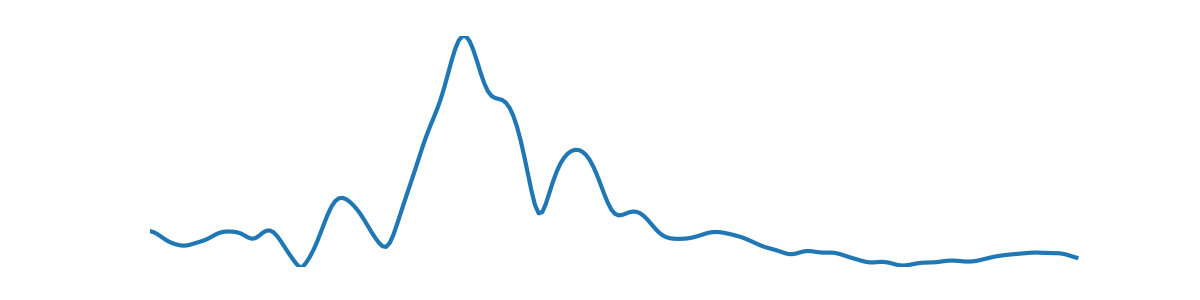

In [15]:
%matplotlib notebook
segment = envelopes[:,1][128:128+256]
plt.figure(figsize=(12,3))
plt.plot(segment, label=r'Mag. de Hilbert', linewidth=3)
plt.axis('off')
plt.xlim([0, len(segment)])
plt.ylim([min(segment), max(segment)])
plt.savefig('Images/Envelope_in_segment.svg', transparent=True)
plt.show()